versions of module used for development:
Python version: 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]
numpy version: 1.26.3
pandas version: 2.1.1
sklearn version: 1.3.2
statsmodels version: 0.14.0
colorama version: 0.4.4
matplotlib version: 3.8.0
re version: 2.2.1
pickle version: 4.0

!pip install numpy==1.26.3 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.0 colorama==0.4.4 matplotlib==3.8.0 pickle==4.0

In [1]:
import numpy as np
import pandas as pd
import warnings
import os, re, math, time
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from colorama import Fore
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pickle

import sklearn
import statsmodels
import colorama
import matplotlib
import sys

warnings.filterwarnings("ignore")

In [2]:
# import file with all input data
pd.set_option('display.max_columns', 20)

df=pd.read_parquet('s3://576118004139-ap-south-1-kbl-datamart-l2/datamartl2/collection_prioritization_v2/cp_features_dcp_v10/20240707_124928_00016_edqr2_e2cd4162-8709-4feb-a239-e73ee74d5713')
df=df[df['hl_present'].notnull()]
# above filter is proxy to remove bureau missing customers

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['td_flag']=np.where(df['avg_td_1m'].isnull(),0,1)
df['max_follow_up_l1m_A002']=np.where(df['max_follow_up_l1m']=='A002',1,0)
df['max_follow_up_l1m_A005']=np.where(df['max_follow_up_l1m']=='A005',1,0)
df['']=np.where(df['max_follow_up_l1m']=='A005',1,0)

df['snap_dt']=df['snap_dt'].astype(str)
df=df.rename(columns={'bad':'good'})
df['stress_cat_1to30']=np.where(df['stress_cat_day0']=='SMA0',1,0)
df['stress_cat_31to60']=np.where(df['stress_cat_day0']=='SMA1',1,0)
df['stress_cat_61to90']=np.where(df['stress_cat_day0']=='SMA2',1,0)

df_dev=df[df['dev']=='1']
# stress_cat_day0,
# stress_days_day0,


df_oot=df[(df['dev']=='0') & (df['snap_dt'].isin(["2023-01-31",'2023-12-31','2024-01-31','2024-02-29','2024-03-31'])) ]

# df_dev.head()
# df_train=df_dev[df_dev['snap_dt'].isin()]




In [3]:
# with open('percentiles_dict_cp.pkl', 'rb') as f:
#     # Load the pickled dictionary
#     percentiles_dict = pickle.load(f)
    
# percentiles_dict.get('active_oda_sanctions')

In [4]:
df_oot['active_oda_sanctions'].value_counts()

active_oda_sanctions
0      44623
1       2147
2       1149
3        669
4        354
5        205
6        141
8        118
7         75
12        72
16        48
9         37
20        24
24        21
10        15
11        13
36        12
28        11
32         6
27         4
44         4
72         4
40         3
13         3
52         2
48         2
15         2
18         2
100        1
68         1
84         1
Name: count, dtype: int64

In [5]:
df_cust=df_dev[df_dev['active_oda_sanctions']==30]

In [6]:
df_cust

Empty DataFrame
Columns: [cust_id, snap_dt, good, dev, active_loans, active_loans_outstanding, active_loans_sanctions, active_oda_outstanding, active_oda_sanctions, avg_followups_perdelq_l1m, avg_followups_perdelq_l3m, avg_followups_perdelq_l6m, avg_mab_12m, avg_mab_1m, avg_mab_3m, avg_mab_6m, avg_td_12m, avg_td_1m, avg_td_3m, avg_td_6m, cnt_12m_loan_closed, cnt_12m_loan_opened, cnt_3m_loan_closed, cnt_3m_loan_opened, cnt_6m_loan_closed, cnt_6m_loan_opened, cnt_loan_opened, cust_marital_status, customer_age, customer_vintage, days_in_stress_l12m, days_in_stress_l3m, days_in_stress_l6m, inward_chq_bounce_l12m_flag, inward_chq_bounce_l24m_flag, inward_chq_bounce_l3m_flag, inward_chq_bounce_l6m_flag, l12m_deposit_amt, l12m_deposit_cnt, l12m_dpd_month_cnt, l3m_deposit_amt, l3m_deposit_cnt, l3m_dpd_month_cnt, l6m_deposit_amt, l6m_deposit_cnt, l6m_dpd_month_cnt, loan_age, loans_30dpd_l12m, loans_30dpd_l3m, loans_30dpd_l6m, loans_3dpd_l12m, loans_3dpd_l3m, loans_3dpd_l6m, loans_5_or_7_dpd_l12m, mab_12m, mab_1m, mab_1m_12m, mab_3m, mab_3m_12m, mab_6m, mab_6m_12m, max_dpd_l12m, max_dpd_l3m, max_dpd_l6m, max_follow_up_days_l1m, max_follow_up_days_l3m, max_follow_up_days_l6m, max_follow_up_l1m, max_follow_up_l3m, max_follow_up_l6m, no_days_contacted_1m, no_days_contacted_3m, no_times_contacted_1m, no_times_contacted_3m, outward_chq_bounce_l12m_flag, outward_chq_bounce_l24m_flag, outward_chq_bounce_l3m_flag, outward_chq_bounce_l6m_flag, promised_to_pay_date, tot_promised_amt, tot_promised_l1m, tot_promised_l3m, tot_promised_l6m, tot_ptp_l1m, tot_ptp_l3m, tot_ptp_l6m, total_promised_paid_l1m, total_promised_paid_l3m, total_promised_paid_l6m, c_amt_3m, d_amt_3m, c_cnt_3m, d_cnt_3m, c_amt_6m, d_amt_6m, c_cnt_6m, d_cnt_6m, c_amt_12m, d_amt_12m, c_cnt_12m, ...]
Index: []

[0 rows x 438 columns]

In [7]:
df_oot['good'].value_counts()

good
1    25223
0    24546
Name: count, dtype: int64

In [8]:
df_dev[df_dev['hl_present'].notnull()].shape


(41853, 438)

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_dev.describe()

good  active_loans  active_loans_sanctions  \
count  41853.000000  41853.000000            41853.000000   
mean       0.498698      3.951401                3.609586   
min        0.000000      1.000000                1.000000   
25%        0.000000      1.000000                1.000000   
50%        0.000000      1.000000                1.000000   
75%        1.000000      4.000000                4.000000   
max        1.000000   1020.000000              867.000000   
std        0.500004     14.752019               12.900685   

       active_oda_sanctions  avg_followups_perdelq_l1m  \
count          41853.000000               40968.000000   
mean               0.341768                   1.376995   
min                0.000000                   1.000000   
25%                0.000000                   1.111111   
50%                0.000000                   1.333333   
75%                0.000000                   1.538462   
max              153.000000                   7.000000   
std                2.265175                   0.352399   

       avg_followups_perdelq_l3m  avg_followups_perdelq_l6m  \
count               41231.000000               41383.000000   
mean                    1.382853                   1.385628   
min                     1.000000                   1.000000   
25%                     1.142857                   1.166667   
50%                     1.333333                   1.333333   
75%                     1.533333                   1.523810   
max                     7.000000                   7.000000   
std                     0.329435                   0.315002   

       cnt_12m_loan_closed  cnt_12m_loan_opened  cnt_3m_loan_closed  \
count          6419.000000          9036.000000         1883.000000   
mean              2.927403             2.519146            2.317578   
min               1.000000             1.000000            1.000000   
25%               1.000000             1.000000            1.000000   
50%               2.000000             1.000000            2.000000   
75%               3.000000             2.000000            2.000000   
max              96.000000           144.000000           42.000000   
std               3.969582             4.189767            2.708087   

       cnt_3m_loan_opened  cnt_6m_loan_closed  cnt_6m_loan_opened  \
count         2335.000000         3667.000000         4719.000000   
mean             2.039829            2.526043            2.262768   
min              1.000000            1.000000            1.000000   
25%              1.000000            1.000000            1.000000   
50%              1.000000            2.000000            1.000000   
75%              2.000000            3.000000            2.000000   
max             65.000000           56.000000           72.000000   
std              2.933956            3.131082            3.397883   

       cnt_loan_opened  customer_age  customer_vintage  days_in_stress_l12m  \
count     41853.000000  41853.000000      40298.000000         41853.000000   
mean         12.458175     45.417557        113.397365           170.208492   
min           1.000000     18.000000        -15.000000             1.000000   
25%           1.000000     37.000000         60.000000            63.000000   
50%           2.000000     45.000000         98.000000           158.000000   
75%           6.000000     53.000000        148.000000           284.000000   
max        5880.000000     94.000000       1119.000000           337.000000   
std          76.251563     11.735512         76.284509           114.753249   

       days_in_stress_l3m  days_in_stress_l6m  inward_chq_bounce_l12m_flag  \
count        41853.000000        41853.000000                 41853.000000   
mean            41.496189           89.672974                     0.279598   
min              1.000000            1.000000                     0.000000   
25%             21.000000           38.000000                     0.000000   
50%       

In [10]:
df_dev['snap_dt'].value_counts()

snap_dt
2023-10-31    9710
2023-08-31    9340
2023-04-30    8124
2023-06-30    7685
2023-02-28    6994
Name: count, dtype: int64

In [11]:
df_oot['snap_dt'].value_counts()

snap_dt
2024-03-31    11580
2024-02-29    10662
2023-12-31    10017
2024-01-31     9868
2023-01-31     7642
Name: count, dtype: int64

In [12]:
df_dev['stress_cat_day0'].value_counts()

stress_cat_day0
SMA0    23433
SMA2     9963
SMA1     8457
Name: count, dtype: int64

In [13]:
# data type conversions

dtype_dict={
'cust_id' : 'str',
'snap_dt' : 'str',
'good' : 'int32',
'dev' : 'str',
'stress_cat_1to30':'int32',
'stress_cat_31to60':'int32',
'stress_cat_61to90':'int32',
# 'oot' : 'str',
'active_loans' : 'int64',
'active_loans_outstanding' : 'float64',
'active_loans_sanctions' : 'int64',
'active_oda_outstanding' : 'float64',
'active_oda_sanctions' : 'int64',
'avg_followups_perdelq_l1m' : 'float64',
'avg_followups_perdelq_l3m' : 'float64',
'avg_followups_perdelq_l6m' : 'float64',
'avg_mab_12m' : 'float64',
'avg_mab_1m' : 'float64',
'avg_mab_3m' : 'float64',
'avg_mab_6m' : 'float64',
'avg_td_12m' : 'float64',
'avg_td_1m' : 'float64',
'avg_td_3m' : 'float64',
'avg_td_6m' : 'float64',
'cnt_12m_loan_closed' : 'float64',
'cnt_12m_loan_opened' : 'float64',
'cnt_3m_loan_closed' : 'float64',
'cnt_3m_loan_opened' : 'float64',
'cnt_6m_loan_closed' : 'float64',
'cnt_6m_loan_opened' : 'float64',
'cnt_loan_opened' : 'int64',
'cust_marital_status' : 'str',
'customer_age' : 'int64',
'customer_vintage' : 'float64',
'days_in_stress_l12m' : 'int64',
'days_in_stress_l3m' : 'int64',
'days_in_stress_l6m' : 'int64',
'inward_chq_bounce_l12m_flag' : 'int32',
'inward_chq_bounce_l24m_flag' : 'int32',
'inward_chq_bounce_l3m_flag' : 'int32',
'inward_chq_bounce_l6m_flag' : 'int32',
'l12m_deposit_amt' : 'float64',
'l12m_deposit_cnt' : 'float64',
'l12m_dpd_month_cnt' : 'int64',
'l3m_dpd_month_cnt' : 'int64',
'l6m_dpd_month_cnt' : 'int64',
'loan_age' : 'int64',
'loans_30dpd_l12m' : 'int64',
'loans_30dpd_l3m' : 'int64',
'loans_30dpd_l6m' : 'int64',
'loans_3dpd_l12m' : 'int64',
'loans_3dpd_l3m' : 'int64',
'loans_3dpd_l6m' : 'int64',
'loans_5_or_7_dpd_l12m' : 'int64',
'mab_12m' : 'float64',
'mab_1m' : 'float64',
'mab_1m_12m' : 'float64',
'mab_3m' : 'float64',
'mab_3m_12m' : 'float64',
'mab_6m' : 'float64',
'mab_6m_12m' : 'float64',
'max_dpd_l12m' : 'float64',
'max_dpd_l3m' : 'float64',
'max_dpd_l6m' : 'float64',
'max_follow_up_days_l1m' : 'float64',
'max_follow_up_days_l3m' : 'float64',
'max_follow_up_days_l6m' : 'float64',
'max_follow_up_l1m' : 'str',
'max_follow_up_l3m' : 'str',
'max_follow_up_l6m' : 'str',
'no_days_contacted_1m' : 'int64',
'no_days_contacted_3m' : 'int64',
'no_times_contacted_1m' : 'int64',
'no_times_contacted_3m' : 'int64',
'outward_chq_bounce_l12m_flag' : 'int32',
'outward_chq_bounce_l24m_flag' : 'int32',
'outward_chq_bounce_l3m_flag' : 'int32',
'outward_chq_bounce_l6m_flag' : 'int32',
'tot_ptp_l1m' : 'int64',
'tot_ptp_l3m' : 'int64',
'tot_ptp_l6m' : 'int64',
'c_amt_3m' : 'float64',
'd_amt_3m' : 'float64',
'c_cnt_3m' : 'int64',
'd_cnt_3m' : 'int64',
'c_amt_6m' : 'float64',
'd_amt_6m' : 'float64',
'c_cnt_6m' : 'int64',
'd_cnt_6m' : 'int64',
'c_amt_12m' : 'float64',
'd_amt_12m' : 'float64',
'c_cnt_12m' : 'int64',
'd_cnt_12m' : 'int64',
'c_cnt_3m_30k_50k' : 'int64',
'c_cnt_3m_50k_75k' : 'int64',
'c_cnt_3m_75k_1l' : 'int64',
'c_cnt_3m_1l_and_above' : 'int64',
'd_cnt_3m_30k_50k' : 'int64',
'd_cnt_3m_50k_75k' : 'int64',
'd_cnt_3m_75k_1l' : 'int64',
'd_cnt_3m_1l_and_above' : 'int64',
'c_cnt_6m_30k_50k' : 'int64',
'c_cnt_6m_50k_75k' : 'int64',
'c_cnt_6m_75k_1l' : 'int64',
'c_cnt_6m_1l_and_above' : 'int64',
'd_cnt_6m_30k_50k' : 'int64',
'd_cnt_6m_50k_75k' : 'int64',
'd_cnt_6m_75k_1l' : 'int64',
'd_cnt_6m_1l_and_above' : 'int64',
'c_cnt_12m_30k_50k' : 'int64',
'c_cnt_12m_50k_75k' : 'int64',
'c_cnt_12m_75k_1l' : 'int64',
'c_cnt_12m_1l_and_above' : 'int64',
'd_cnt_12m_30k_50k' : 'int64',
'd_cnt_12m_50k_75k' : 'int64',
'd_cnt_12m_75k_1l' : 'int64',
'd_cnt_12m_1l_and_above' : 'int64',
'm1_atm_credit_amt' : 'float64',
'm1_upi_credit_amt' : 'float64',
'm1_neft_credit_amt' : 'float64',
'm1_rtgs_credit_amt' : 'float64',
'm1_imps_credit_amt' : 'float64',
'm1_cash_chq_amt' : 'float64',
'm3_atm_credit_amt' : 'float64',
'm3_upi_credit_amt' : 'float64',
'm3_neft_credit_amt' : 'float64',
'm3_rtgs_credit_amt' : 'float64',
'm3_imps_credit_amt' : 'float64',
'm3_cash_chq_amt' : 'float64',
'm6_atm_credit_amt' : 'float64',
'm6_upi_credit_amt' : 'float64',
'm6_neft_credit_amt' : 'float64',
'm6_rtgs_credit_amt' : 'float64',
'm6_imps_credit_amt' : 'float64',
'm6_cash_chq_amt' : 'float64',
'm12_atm_credit_amt' : 'float64',
'm12_upi_credit_amt' : 'float64',
'm12_neft_credit_amt' : 'float64',
'm12_rtgs_credit_amt' : 'float64',
'm12_imps_credit_amt' : 'float64',
'm12_cash_chq_amt' : 'float64',
'm1_atm_debit_amt' : 'float64',
'm1_upi_debit_amt' : 'float64',
'm1_neft_debit_amt' : 'float64',
'm1_rtgs_debit_amt' : 'float64',
'm1_imps_debit_amt' : 'float64',
'm3_atm_debit_amt' : 'float64',
'm3_upi_debit_amt' : 'float64',
'm3_neft_debit_amt' : 'float64',
'm3_rtgs_debit_amt' : 'float64',
'm3_imps_debit_amt' : 'float64',
'm6_atm_debit_amt' : 'float64',
'm6_upi_debit_amt' : 'float64',
'm6_neft_debit_amt' : 'float64',
'm6_rtgs_debit_amt' : 'float64',
'm6_imps_debit_amt' : 'float64',
'm12_atm_debit_amt' : 'float64',
'm12_upi_debit_amt' : 'float64',
'm12_neft_debit_amt' : 'float64',
'm12_rtgs_debit_amt' : 'float64',
'm12_imps_debit_amt' : 'float64',
'c2d_amt_3m' : 'float64',
'c2d_cnt_3m' : 'float64',
'c2d_amt_6m' : 'float64',
'c2d_cnt_6m' : 'float64',
'c2d_amt_12m' : 'float64',
'c2d_cnt_12m' : 'float64',
'age_newest_active_trd' : 'float64',
'age_newest_trade' : 'float64',
'age_oldest_active_trd' : 'float64',
'al_opnd_l12m' : 'float64',
'al_opnd_l18m' : 'float64',
'al_opnd_l24m' : 'float64',
'al_opnd_l6m' : 'float64',
'al_present' : 'float64',
'al_present_ever' : 'float64',
'avg_loan_cnt_ge50k_l2yrs' : 'float64',
'avg_loan_cnt_gt10k_l2yrs' : 'float64',
'bl_present' : 'float64',
'bl_present_ever' : 'float64',
'bureau_credit_age' : 'float64',
'bureau_score_band' : 'str',
'bureau_score_latest' : 'float64',
'cc_bal_l12m' : 'float64',
'cc_bal_l18m' : 'float64',
'cc_bal_l24m' : 'float64',
'cc_bal_l6m' : 'float64',
'cc_limit_max_l12m' : 'float64',
'cc_limit_max_l18m' : 'float64',
'cc_limit_max_l24m' : 'float64',
'cc_limit_max_l6m' : 'float64',
'cc_opnd_l12m' : 'float64',
'cc_opnd_l18m' : 'float64',
'cc_opnd_l24m' : 'float64',
'cc_opnd_l6m' : 'float64',
'cc_present' : 'float64',
'cc_present_ever' : 'float64',
'cc_util_12m_avg' : 'float64',
'cc_util_18m_avg' : 'float64',
'cc_util_24m_avg' : 'float64',
'cc_util_6m_avg' : 'float64',
'cnt_loan_cnt_ge50k_l18m' : 'float64',
'cnt_loan_cnt_ge50k_l1yrs' : 'float64',
'cnt_loan_cnt_gt10k_l6m' : 'float64',
'cntl12m0plus' : 'float64',
'cntl12m30plus' : 'float64',
'cntl12m60plus' : 'float64',
'cntl12m90plus' : 'float64',
'cntl6m0plus' : 'float64',
'cntl6m30plus' : 'float64',
'cntl6m60plus' : 'float64',
'cntl6m90plus' : 'float64',
'consumer_loan_opnd_l12m' : 'float64',
'consumer_loan_opnd_l18m' : 'float64',
'consumer_loan_opnd_l24m' : 'float64',
'consumer_loan_opnd_l6m' : 'float64',
'consumer_loan_present' : 'float64',
'consumer_loan_present_ever' : 'float64',
'exposure_increase_bureau_l6m_l12m' : 'float64',
'gold_loan_opnd_l12m' : 'float64',
'gold_loan_opnd_l18m' : 'float64',
'gold_loan_opnd_l24m' : 'float64',
'gold_loan_opnd_l6m' : 'float64',
'goldl_present' : 'float64',
'goldl_present_ever' : 'float64',
'groupl_present' : 'float64',
'groupl_present_ever' : 'float64',
'highest_dpd_l12m' : 'float64',
'highest_dpd_l18m' : 'float64',
'highest_dpd_l24m' : 'float64',
'highest_dpd_l6m' : 'float64',
'hl_present' : 'float64',
'hl_present_ever' : 'float64',
'l12_written_off' : 'float64',
'l12m30forward' : 'float64',
'l12m30plus' : 'float64',
'l12m30recovery' : 'float64',
'l12m60forward' : 'float64',
'l12m60plus' : 'float64',
'l12m60recovery' : 'float64',
'l12m90plus' : 'float64',
'l24m_written_off' : 'float64',
'l24m30plus' : 'float64',
'l24m60plus' : 'float64',
'l24m90plus' : 'float64',
'l3m30forward' : 'float64',
'l3m30recovery' : 'float64',
'l3m60forward' : 'float64',
'l3m60recovery' : 'float64',
'l6m30forward' : 'float64',
'l6m30plus' : 'float64',
'l6m30recovery' : 'float64',
'l6m60forward' : 'float64',
'l6m60plus' : 'float64',
'l6m60recovery' : 'float64',
'l6m90plus' : 'float64',
'l9m30forward' : 'float64',
'l9m30recovery' : 'float64',
'l9m60forward' : 'float64',
'l9m60recovery' : 'float64',
'latest_tot_bal_all_prd' : 'float64',
'latest_tot_bal_secured' : 'float64',
'latest_tot_bal_unsecured' : 'float64',
'loan_outstanding_bal_l12m_l24m' : 'float64',
'loan_outstanding_bal_l6m_l12m' : 'float64',
'max_sanc_amt_secured_l12m' : 'float64',
'max_sanc_amt_secured_l18m' : 'float64',
'max_sanc_amt_secured_l24m' : 'float64',
'max_sanc_amt_secured_l6m' : 'float64',
'max_sanc_amt_unsecured_l12m' : 'float64',
'max_sanc_amt_unsecured_l18m' : 'float64',
'max_sanc_amt_unsecured_l24m' : 'float64',
'max_sanc_amt_unsecured_l6m' : 'float64',
'median_loan_amount_l12m' : 'float64',
'median_loan_amount_l18m' : 'float64',
'median_loan_amount_l24m' : 'float64',
'median_loan_amount_l6m' : 'float64',
'mfi_opnd_l12m' : 'float64',
'mfi_opnd_l18m' : 'float64',
'mfi_opnd_l24m' : 'float64',
'mfi_opnd_l6m' : 'float64',
'mfi_present' : 'float64',
'mfi_present_ever' : 'float64',
'month_since_cc_inq_l24m' : 'float64',
'month_since_first_loan_ge50k' : 'float64',
'month_since_last_loan_inq_l24m' : 'float64',
'month_since_last30plus_l24m' : 'float64',
'month_since_last60plus_l24m' : 'float64',
'month_since_last90plus_l24m' : 'float64',
'month_since_pl_inq_l24m' : 'float64',
'month_since_secured_inq' : 'float64',
'month_since_unsecured_inq' : 'float64',
'no_inq_cc_l12m' : 'float64',
'no_inq_cc_l18m' : 'float64',
'no_inq_cc_l24m' : 'float64',
'no_inq_cc_l6m' : 'float64',
'no_inq_l12m' : 'float64',
'no_inq_l18m' : 'float64',
'no_inq_l24m' : 'float64',
'no_inq_l6m' : 'float64',
'no_inq_pl_l12m' : 'float64',
'no_inq_pl_l18m' : 'float64',
'no_inq_pl_l24m' : 'float64',
'no_inq_pl_l6m' : 'float64',
'no_inq_secured_l12m' : 'float64',
'no_inq_secured_l18m' : 'float64',
'no_inq_secured_l24m' : 'float64',
'no_inq_secured_l6m' : 'float64',
'no_inq_unsecured_l12m' : 'float64',
'no_inq_unsecured_l18m' : 'float64',
'no_inq_unsecured_l24m' : 'float64',
'no_inq_unsecured_l6m' : 'float64',
'no_months_max_dpd10_l12m' : 'float64',
'no_months_max_dpd3_l12m' : 'float64',
'no_months_max_dpd5_l12m' : 'float64',
'no_months_max_dpd7_l12m' : 'float64',
'num_loans_closed_max_0dpd' : 'float64',
'num_loans_closed_max_10dpd' : 'float64',
'num_loans_closed_max_20dpd' : 'float64',
'num_loans_closed_max_30dpd' : 'float64',
'num_loans_gt30del_l12m' : 'float64',
'num_loans_gt30del_l18m' : 'float64',
'num_loans_gt30del_l24m' : 'float64',
'num_loans_gt30del_l6m' : 'float64',
'num_loans_gt60del_l12m' : 'float64',
'num_loans_gt60del_l18m' : 'float64',
'num_loans_gt60del_l24m' : 'float64',
'num_loans_gt60del_l6m' : 'float64',
'num_loans_gt90del_l12m' : 'float64',
'num_loans_gt90del_l18m' : 'float64',
'num_loans_gt90del_l24m' : 'float64',
'num_loans_gt90del_l6m' : 'float64',
'num_loans_lt30del_l12m' : 'float64',
'num_loans_lt30del_l18m' : 'float64',
'num_loans_lt30del_l24m' : 'float64',
'num_loans_lt30del_l6m' : 'float64',
'od_opnd_l12m' : 'float64',
'od_opnd_l18m' : 'float64',
'od_opnd_l24m' : 'float64',
'od_opnd_l6m' : 'float64',
'od_present' : 'float64',
'od_present_ever' : 'float64',
'overdue_amt_l12m' : 'float64',
'overdue_amt_l18m' : 'float64',
'overdue_amt_l24m' : 'float64',
'overdue_amt_l6m' : 'float64',
'percent_del_amt_l12m' : 'float64',
'pl_opnd_l12m' : 'float64',
'pl_opnd_l18m' : 'float64',
'pl_opnd_l24m' : 'float64',
'pl_opnd_l6m' : 'float64',
'pl_present' : 'float64',
'pl_present_ever' : 'float64',
'professional_loan_present' : 'float64',
'professional_loan_present_ever' : 'float64',
'ratio_sec_trd_opn_l12m_tot_l12m_opn' : 'float64',
'ratio_sec_trd_opn_l12m_tot_opn' : 'float64',
'ratio_sec_trd_opn_l18m_tot_l18m_opn' : 'float64',
'ratio_sec_trd_opn_l18m_tot_opn' : 'float64',
'ratio_sec_trd_opn_l24m_tot_l24m_opn' : 'float64',
'ratio_sec_trd_opn_l24m_tot_opn' : 'float64',
'ratio_sec_trd_opn_l6m_tot_l6m_opn' : 'float64',
'ratio_sec_trd_opn_l6m_tot_opn' : 'float64',
'ratio_sec_trd_opn_tot' : 'float64',
'ratio_trade_amt_opnd_clsed_l12m' : 'float64',
'ratio_trade_amt_opnd_clsed_l24m' : 'float64',
'ratio_trade_amt_opnd_clsed_l6m' : 'float64',
'ratio_trd_clsd_l12m_tot_clsd' : 'float64',
'ratio_trd_clsd_l18m_tot_clsd' : 'float64',
'ratio_trd_clsd_l24m_tot_clsd' : 'float64',
'ratio_trd_clsd_l6m_tot_clsd' : 'float64',
'ratio_trd_clsd_opn_l12m' : 'float64',
'ratio_trd_clsd_opn_l18m' : 'float64',
'ratio_trd_clsd_opn_l24m' : 'float64',
'ratio_trd_clsd_opn_l6m' : 'float64',
'ratio_trd_opn_l12m_tot_opn' : 'float64',
'ratio_trd_opn_l18m_tot_opn' : 'float64',
'ratio_trd_opn_l24m_tot_opn' : 'float64',
'ratio_trd_opn_l6m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l12m_tot_l12m_opn' : 'float64',
'ratio_unsec_trd_opn_l12m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l18m_tot_l18m_opn' : 'float64',
'ratio_unsec_trd_opn_l18m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l24m_tot_l24m_opn' : 'float64',
'ratio_unsec_trd_opn_l24m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_l6m_tot_l6m_opn' : 'float64',
'ratio_unsec_trd_opn_l6m_tot_opn' : 'float64',
'ratio_unsec_trd_opn_tot' : 'float64',
'ratio0plusinl6mto12m' : 'float64',
'ratio30plusinl6mto12m' : 'float64',
'ratio60plusinl6mto12m' : 'float64',
'ratio90plusinl6mto12m' : 'float64',
'securedl_present' : 'float64',
'securedl_present_ever' : 'float64',
'tot_clsd_trades' : 'float64',
'tot_opn_trades' : 'float64',
'tot_sec_trades_open' : 'float64',
'tot_sec_trades_open_l12m' : 'float64',
'tot_sec_trades_open_l18m' : 'float64',
'tot_sec_trades_open_l24m' : 'float64',
'tot_sec_trades_open_l6m' : 'float64',
'tot_unsec_trades_open' : 'float64',
'tot_unsec_trades_open_l12m' : 'float64',
'tot_unsec_trades_open_l18m' : 'float64',
'tot_unsec_trades_open_l24m' : 'float64',
'tot_unsec_trades_open_l6m' : 'float64',
'trade_clsd_l12m' : 'float64',
'trade_clsd_l18m' : 'float64',
'trade_clsd_l24m' : 'float64',
'trade_clsd_l6m' : 'float64',
'trade_opn_l12m' : 'float64',
'trade_opn_l18m' : 'float64',
'trade_opn_l24m' : 'float64',
'trade_opn_l6m' : 'float64',
'stress_cat_day0' : 'str',
'stress_days_day0' : 'int32',
'exposure' : 'float64',
'retail_flag' : 'int32',
'msme_loan' : 'int32',
'tot_active_trades':'float64',
'num_loans_gt60del_l24m':'float64',
'no_months_no_del_l12m':'int32',
'max_follow_up_l1m_A002':'int32',
'max_follow_up_l1m_A005':'int32'
,'td_flag':'int32'
}

df_dev = df_dev.astype(dtype_dict)
df_oot = df_oot.astype(dtype_dict)

In [14]:
# df.groupby(['msme_loan']).agg({'exposure':'mean'})

In [15]:
# for col in df.columns:
    # print(df[col].value_counts())
    
    
#     checking missing values
    
try:
    100*(df_dev.isnull().sum()/len(df_dev)).to_csv('missing_counts.csv')
except:
    print('continue')

continue


In [16]:
# drop mostly missing columns
print(df_dev.shape)


# dropping columns with very less population

df_dev=df_dev.drop([
    'l3m_deposit_amt',
'l3m_deposit_cnt',
'l6m_deposit_amt',
'l6m_deposit_cnt',
'total_promised_paid_l1m',
'tot_promised_l1m',
'total_promised_paid_l3m',
'total_promised_paid_l6m',
'month_since_gl_inq_l24m',
'tot_promised_l3m',
'promised_to_pay_date',
'tot_promised_l6m',
'tot_promised_amt'],axis=1)

print(df_dev.shape)

(41853, 438)
(41853, 425)


In [17]:

# to check monotonicity of a series


def is_monotonic(temp_series):
    return all(temp_series[i] <= temp_series[i + 1] for i in range(len(temp_series) - 1)) or all(temp_series[i] >= temp_series[i + 1] for i in range(len(temp_series) - 1))

def prepare_bins(bin_data, c_i, target_col, max_bins):
    force_bin = True
    binned = False
    remarks = np.nan
    # ----------------- Monotonic binning -----------------
    for n_bins in range(max_bins, 5, -1):
        try:
            bin_data[c_i + "_bins"] = pd.qcut(bin_data[c_i], n_bins, duplicates="drop")
            monotonic_series = bin_data.groupby(c_i + "_bins")[target_col].mean().reset_index(drop=True)
            if is_monotonic(monotonic_series):
                force_bin = False
                binned = True
                remarks = "binned monotonically"
                break
        except:
            pass
    # ----------------- Force binning -----------------
    # creating 2 bins forcefully because 2 bins will always be monotonic
    if force_bin or (c_i + "_bins" in bin_data and bin_data[c_i + "_bins"].nunique() < 2):
        _min=bin_data[c_i].min()
        _mean=bin_data[c_i].mean()
        _max=bin_data[c_i].max()
        # print(c_i)
        bin_data[c_i + "_bins"] = pd.cut(bin_data[c_i], [_min, _mean, _max], include_lowest=True)
        if bin_data[c_i + "_bins"].nunique() == 2:
            binned = True
            remarks = "binned forcefully"
    
    if binned:
        return c_i + "_bins", remarks, bin_data[[c_i, c_i+"_bins", target_col]].copy()
    else:
        remarks = "couldn't bin"
        return c_i, remarks, bin_data[[c_i, target_col]].copy()

# calculate WOE and IV for every group/bin/class for a provided feature
def iv_woe_4iter(binned_data, target_col, class_col):
    if "_bins" in class_col:
        binned_data[class_col] = binned_data[class_col].cat.add_categories(['Missing'])
        binned_data[class_col] = binned_data[class_col].fillna("Missing")
        temp_groupby = binned_data.groupby(class_col).agg({class_col.replace("_bins", ""):["min", "max"],
                                                           target_col: ["count", "sum", "mean"]}).reset_index()
    else:
        binned_data[class_col] = binned_data[class_col].fillna("Missing")
        temp_groupby = binned_data.groupby(class_col).agg({class_col:["first", "first"],
                                                           target_col: ["count", "sum", "mean"]}).reset_index()
    
    temp_groupby.columns = ["sample_class", "min_value", "max_value", "sample_count", "event_count", "event_rate"]
    temp_groupby["non_event_count"] = temp_groupby["sample_count"] - temp_groupby["event_count"]
    temp_groupby["non_event_rate"] = 1 - temp_groupby["event_rate"]
    temp_groupby = temp_groupby[["sample_class", "min_value", "max_value", "sample_count",
                                 "non_event_count", "non_event_rate", "event_count", "event_rate"]]
    
    if "_bins" not in class_col and "Missing" in temp_groupby["min_value"]:
        temp_groupby["min_value"] = temp_groupby["min_value"].replace({"Missing": np.nan})
        temp_groupby["max_value"] = temp_groupby["max_value"].replace({"Missing": np.nan})
    temp_groupby["feature"] = class_col
    if "_bins" in class_col:
        temp_groupby["sample_class_label"]=temp_groupby["sample_class"].replace({"Missing": np.nan}).astype('category').cat.codes.replace({-1: np.nan})
    else:
        temp_groupby["sample_class_label"]=np.nan
    temp_groupby = temp_groupby[["feature", "sample_class", "sample_class_label", "sample_count", "min_value", "max_value",
                                 "non_event_count", "non_event_rate", "event_count", "event_rate"]]
    
    """
    **********get distribution of good and bad
    """
    temp_groupby['distbn_non_event'] = temp_groupby["non_event_count"]/temp_groupby["non_event_count"].sum()
    temp_groupby['distbn_event'] = temp_groupby["event_count"]/temp_groupby["event_count"].sum()

    temp_groupby['woe'] = np.log(temp_groupby['distbn_non_event'] / temp_groupby['distbn_event'])
    temp_groupby['iv'] = (temp_groupby['distbn_non_event'] - temp_groupby['distbn_event']) * temp_groupby['woe']
    
    temp_groupby["woe"] = temp_groupby["woe"].replace([np.inf,-np.inf],0)
    temp_groupby["iv"] = temp_groupby["iv"].replace([np.inf,-np.inf],0)
    
    return temp_groupby

"""
- iterate over all features.
- calculate WOE & IV for there classes.
- append to one DataFrame woe_iv.
"""
def var_iter(data, target_col, max_bins):
    woe_iv = pd.DataFrame()
    remarks_list = []
    for c_i in data.columns:
        if c_i not in [target_col]:
            # check if binning is required. if yes, then prepare bins and calculate woe and iv.
            """
            ----logic---
            binning is done only when feature is continuous and non-binary.
            Note: Make sure dtype of continuous columns in dataframe is not object.
            """
            c_i_start_time=time.time()
            if np.issubdtype(data[c_i], np.number) and data[c_i].nunique() > 2:
                class_col, remarks, binned_data = prepare_bins(data[[c_i, target_col]].copy(), c_i, target_col, max_bins)
                agg_data = iv_woe_4iter(binned_data.copy(), target_col, class_col)
                remarks_list.append({"feature": c_i, "remarks": remarks})
                # remarks_list = pd.concat([remarks_list, {"feature": c_i, "remarks": remarks}])
            else:
                agg_data = iv_woe_4iter(data[[c_i, target_col]].copy(), target_col, c_i)
                # remarks_list = pd.concat([remarks_list, {"feature": c_i, "remarks": "categorical"}])
                remarks_list.append({"feature": c_i, "remarks": "categorical"})
            # print("---{} seconds. c_i: {}----".format(round(time.time() - c_i_start_time, 2), c_i))
            woe_iv = pd.concat([woe_iv, agg_data])
            # woe_iv = woe_iv.append(agg_data)
    return woe_iv, pd.DataFrame(remarks_list)

# after getting woe and iv for all classes of features calculate aggregated IV values for features.
def get_iv_woe(data, target_col, max_bins):
    func_start_time = time.time()
    woe_iv, binning_remarks = var_iter(data, target_col, max_bins)
    print("------------------IV and WOE calculated for individual groups.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    
    woe_iv["feature"] = woe_iv["feature"].replace("_bins", "", regex=True)    
    woe_iv = woe_iv[["feature", "sample_class", "sample_class_label", "sample_count", "min_value", "max_value",
                     "non_event_count", "non_event_rate", "event_count", "event_rate", 'distbn_non_event',
                     'distbn_event', 'woe', 'iv']]
    
    iv = woe_iv.groupby("feature")[["iv"]].agg(["sum", "count"]).reset_index()
    print("------------------Aggregated IV values for features calculated.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    
    iv.columns = ["feature", "iv", "number_of_classes"]
    null_percent_data=pd.DataFrame(data.isnull().mean()).reset_index()
    null_percent_data.columns=["feature", "feature_null_percent"]
    iv=iv.merge(null_percent_data, on="feature", how="left")
    print("------------------Null percent calculated in features.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    iv = iv.merge(binning_remarks, on="feature", how="left")
    woe_iv = woe_iv.merge(iv[["feature", "iv", "remarks"]].rename(columns={"iv": "iv_sum"}), on="feature", how="left")
    print("------------------Binning remarks added and process is complete.------------------")
    print("Total time elapsed: {} minutes".format(round((time.time() - func_start_time) / 60, 3)))
    return iv, woe_iv.replace({"Missing": np.nan})

In [18]:
# using above ks function to get woe and IV
IV,final_iv = get_iv_woe(df_dev.loc[:, ~df_dev.columns.isin(['cust_id','snap_dt'])], target_col="good", max_bins=8)

------------------IV and WOE calculated for individual groups.------------------
Total time elapsed: 0.167 minutes
------------------Aggregated IV values for features calculated.------------------
Total time elapsed: 0.167 minutes
------------------Null percent calculated in features.------------------
Total time elapsed: 0.168 minutes
------------------Binning remarks added and process is complete.------------------
Total time elapsed: 0.168 minutes


In [19]:

# saving iv and woe to file
final_iv.to_csv("woe_iv_cp.csv")
IV.to_csv("iv_cp.csv")

In [20]:


# import pickle
# numeric_cols = df_dev.select_dtypes(include=np.number).columns.to_list()
# cols_bool=[col for col in df_dev.columns if df_dev[col].isin([0, 1]).all()]   

# percentiles_dict={}

# for col in numeric_cols:
#     if col not in cols_bool:
#         percentiles = df_dev[col].quantile([0.01, 0.99]).values
#         # print(percentiles)
#         percentiles_dict[col] = (percentiles[0], percentiles[1])
#         df_dev[col][df_dev[col] <= percentiles[0]] = percentiles[0]
#         df_dev[col][df_dev[col] >= percentiles[1]] = percentiles[1]
        
# # print(percentiles_dict)
# print('capping flooring done')
# with open('percentiles_dict_cp.pkl', 'wb') as file:
#     pickle.dump(percentiles_dict, file)
    
# with open('cols_bool_cp.pkl', 'wb') as f:
#     pickle.dump(cols_bool, f)

# with open('numeric_cols_cp.pkl', 'wb') as f:
#     pickle.dump(numeric_cols, f)


In [21]:
# pd.DataFrame(percentiles_dict).to_csv('capping_values.csv')

In [22]:
# correlation checks

ftrs=[
'good',
'cntl6m30plus', 
'month_since_last30plus_l24m',
'max_dpd_l3m',
    'max_dpd_l6m',
    'days_in_stress_l3m',
    'days_in_stress_l12m',
    'max_dpd_l12m',
    'stress_days_day0',
'l6m_dpd_month_cnt',
'l3m_dpd_month_cnt',
'l3m30forward',
'l12m30forward',
'avg_mab_6m',
    # 'l12m_dpd_month_cnt',
'max_sanc_amt_secured_l24m',
'ratio_trd_opn_l18m_tot_opn',

'c_amt_3m',
'percent_del_amt_l12m',
# 'ratio0plusinl6mto12m',
'm6_neft_credit_amt',
'overdue_amt_l6m',

'loan_outstanding_bal_l12m_l24m',
'c_cnt_12m_1l_and_above',
# 'hl_present_ever',
'c_cnt_6m_30k_50k',
# 'l6m30recovery',
'no_times_contacted_3m',
'median_loan_amount_l24m',
# 'l6m60recovery',
'max_sanc_amt_unsecured_l18m',
'l24m30plus',
# 'gold_loan_opnd_l24m',
# 'cc_present',
# 'avg_followups_perdelq_l3m',
# 'cc_opnd_l18m',
# 'exposure',
# 'loan_outstanding_bal_l6m_l12m',
# 'ratio_unsec_trd_opn_l18m_tot_l18m_opn',
'l3m60forward',
'l24m_written_off',
# 'l24m60plus'
# 'm12_upi_credit_amt'
# m6_atm_credit_amt
# max_sanc_amt_unsecured_l6m
'cc_opnd_l6m',
# m12_atm_credit_amt
    
'active_oda_sanctions',
    'cntl12m30plus'
    ]

def plot_correlation_matrix(data):
    # corr_pearson = data.corr(method="pearson")
    corr_spearman = data.corr(method="spearman")
    # corr_pearson.to_csv('corr_pearson.csv')
    corr_spearman.to_csv('corr_spearman.csv')

plot_correlation_matrix(df_dev[ftrs].loc[:, ~df_dev[ftrs].columns.isin(['cust_id',
                                                            'snap_dt',
                                                            'cust_id',
                                                            'dev',
                                                            'cust_marital_status',
                                                            'bureau_score_band',
                                                            'stress_cat_day0',
                                                            'max_follow_up_l1m',
                                                            'max_follow_up_l3m',
                                                            'max_follow_up_l6m'
                                                           ])])

In [23]:
# filtering out not required tables
columns=[
'good',
'bureau_score_band',
'bureau_score_latest',
'month_since_last30plus_l24m',
'avg_mab_6m',
'c_amt_3m',
'm6_neft_credit_amt',
'c_cnt_6m_30k_50k',
'c_cnt_12m_1l_and_above',
'c_cnt_12m_75k_1l',
'c_cnt_6m_50k_75k',
'm6_imps_credit_amt',
'max_sanc_amt_unsecured_l18m',
'median_loan_amount_l24m',
'm12_atm_credit_amt',
'active_oda_sanctions',
'max_sanc_amt_secured_l24m',
'm12_upi_credit_amt',
'ratio_trd_opn_l18m_tot_opn',
'm12_rtgs_credit_amt',
'm6_atm_credit_amt',
'max_sanc_amt_unsecured_l6m',
'cc_opnd_l18m',
'l12m_deposit_amt',
'tot_ptp_l1m',
'cc_opnd_l6m',
'cc_present',
'ratio_unsec_trd_opn_l18m_tot_l18m_opn',
'l12m_deposit_cnt',
'ratio_trd_clsd_l12m_tot_clsd',
'cnt_6m_loan_closed',
'hl_present_ever',
'al_present_ever',
'exposure',
'customer_vintage',
'customer_age',
'mab_6m_12m',
'mfi_present_ever',
'num_loans_gt90del_l24m',
'no_inq_unsecured_l18m',
'loan_outstanding_bal_l12m_l24m',
'no_inq_secured_l18m',
'goldl_present_ever',
'avg_followups_perdelq_l3m',
'avg_followups_perdelq_l6m',
'gold_loan_opnd_l24m',
'no_times_contacted_3m',
'loan_outstanding_bal_l6m_l12m',
'no_inq_l18m',
'l24m_written_off',
'ratio0plusinl6mto12m',
'l6m30recovery',
'l24m90plus',
'l3m30forward',
'percent_del_amt_l12m',
'l6m60recovery',
'l3m60forward',
'l12m30forward',
'l6m_dpd_month_cnt',
'l3m_dpd_month_cnt',
'cntl6m30plus',
'overdue_amt_l6m',
'max_dpd_l3m',
'l24m30plus'
,'stress_days_day0'
,'max_dpd_l6m'
,'days_in_stress_l3m'
,'max_dpd_l12m'
,'days_in_stress_l12m'
,'cntl12m30plus'
,'month_since_last60plus_l24m'
,'l12m_dpd_month_cnt'
,'stress_cat_day0'
,'stress_cat_1to30'
,'stress_cat_31to60'
,'stress_cat_61to90'
,'c_cnt_6m_75k_1l'
,'c_cnt_6m_1l_and_above'
,'tot_active_trades'
,'num_loans_gt60del_l24m'
,'days_in_stress_l6m'
,'no_months_max_dpd3_l12m'
,'no_months_no_del_l12m'
,'l6m30plus'
,'max_follow_up_l1m_A002'
,'max_follow_up_l1m_A005'
,'cnt_loan_cnt_ge50k_l18m'
,'age_newest_trade'
,'max_follow_up_days_l6m'
,'ratio60plusinl6mto12m'
,'td_flag'
,'month_since_first_loan_ge50k'
,'bureau_credit_age'
,'no_inq_l24m'
,'no_inq_l12m'
,'no_inq_l6m'
# ,'gold_loan_opnd_l24m'
]

df_model_input=df_dev[columns]

In [24]:

# one hot encode bureau score 
# df_model_input=bureau_score_band.bureau_score_band

df_model_input = pd.get_dummies(df_model_input, columns=['bureau_score_band'])

In [25]:
# overview remaining columns
df_model_input.head()

good  bureau_score_latest  month_since_last30plus_l24m   avg_mab_6m  \
4      1                490.0                          NaN  2216.659479   
7      0                402.0                          1.0   590.086756   
9      0                469.0                          1.0   337.771685   
10     1                539.0                          5.0   335.063383   
14     1                300.0                          1.0          NaN   

    c_amt_3m  m6_neft_credit_amt  c_cnt_6m_30k_50k  c_cnt_12m_1l_and_above  \
4   449835.0                 0.0                 5                       0   
7    77800.0                 0.0                 2                       0   
9    64000.0                 0.0                 0                       0   
10   25000.0                 0.0                 0                       0   
14       0.0                 0.0                 0                       0   

    c_cnt_12m_75k_1l  c_cnt_6m_50k_75k  m6_imps_credit_amt  \
4                  0                 0                 0.0   
7                  0                 0                 0.0   
9                  0                 0                 0.0   
10                 0                 0             76000.0   
14                 0                 0                 0.0   

    max_sanc_amt_unsecured_l18m  median_loan_amount_l24m  m12_atm_credit_amt  \
4                      200000.0             200000.00000             20000.0   
7                           0.0              74438.77551                 0.0   
9                       27903.0              10000.00000                 0.0   
10                      89000.0             135500.00000                 0.0   
14                       9000.0               9000.00000                 0.0   

    active_oda_sanctions  max_sanc_amt_secured_l24m  m12_upi_credit_amt  \
4                      0                        NaN               580.0   
7                      0                   247000.0                 0.0   
9                      1                    60000.0                 0.0   
10                     0                  1250800.0                 0.0   
14                     0                   158158.0                 0.0   

    ratio_trd_opn_l18m_tot_opn  m12_rtgs_credit_amt  m6_atm_credit_amt  \
4                     1.000000                  0.0                0.0   
7                     0.454545                  0.0                0.0   
9                     0.125000                  0.0                0.0   
10                    0.500000                  0.0                0.0   
14                    0.666667                  0.0                0.0   

    max_sanc_amt_unsecured_l6m  cc_opnd_l18m  l12m_deposit_amt  tot_ptp_l1m  \
4                          0.0           0.0               NaN            2   
7                          0.0           0.0               NaN            0   
9                      27903.0           0.0               NaN            0   
10                         0.0           0.0               NaN            1   
14                         0.0           0.0               NaN            0   

    cc_opnd_l6m  cc_present  ratio_unsec_trd_opn_l18m_tot_l18m_opn  \
4           0.0         0.0                                  1.000   
7           0.0         0.0                                  0.000   
9           0.0         0.0                                  1.000   
10          0.0         0.0                                  0.400   
14          0.0         1.0                                  0.125   

    l12m_deposit_cnt  ratio_trd_clsd_l12m_tot_clsd  cnt_6m_loan_closed  \
4                NaN                           NaN                 NaN   
7                NaN                      0.666667                 NaN   
9                NaN                      0.500000                 NaN   
10               NaN                      0.800000                 1.0   
14               NaN                      1.000000                 N

In [33]:

df_dev['c_cnt_6m_ge30K'] =df_dev['c_cnt_6m_30k_50k']+df_model_input['c_cnt_6m_50k_75k']+df_model_input['c_cnt_6m_75k_1l']+df_model_input['c_cnt_6m_1l_and_above']

In [34]:
df_dev['c_cnt_6m_ge30K']=df_dev['c_cnt_6m_ge30K'].astype(float)

In [35]:
# pickling flooring and capping files 

import pickle
numeric_cols = df_dev.select_dtypes(include=np.number).columns.to_list()
cols_bool=[col for col in df_dev.columns if df_dev[col].isin([0, 1]).all()]   

percentiles_dict={}

for col in numeric_cols:
    if col not in cols_bool:
        percentiles = df_dev[col].quantile([0.01, 0.99]).values
        # print(percentiles)
        percentiles_dict[col] = (percentiles[0], percentiles[1])
        df_dev[col][df_dev[col] <= percentiles[0]] = percentiles[0]
        df_dev[col][df_dev[col] >= percentiles[1]] = percentiles[1]
        
# print(percentiles_dict)
print('capping flooring done')
with open('percentiles_dict_cp.pkl', 'wb') as file:
    pickle.dump(percentiles_dict, file)
    
with open('cols_bool_cp.pkl', 'wb') as f:
    pickle.dump(cols_bool, f)

with open('numeric_cols_cp.pkl', 'wb') as f:
    pickle.dump(numeric_cols, f)


capping flooring done


In [36]:
# combine all >=30k credit counts to get new column
percentiles_dict

{'active_loans': (1.0, 42.331776000006634),
 'active_loans_outstanding': (8063.71696128, 227443744.73337615),
 'active_loans_sanctions': (1.0, 40.0),
 'active_oda_outstanding': (191114.22977799998, 5122330915.892736),
 'active_oda_sanctions': (0.0, 7.0),
 'avg_followups_perdelq_l1m': (1.0, 2.5),
 'avg_followups_perdelq_l3m': (1.0, 2.5),
 'avg_followups_perdelq_l6m': (1.0, 2.4545454545454546),
 'avg_mab_12m': (0.0, 232267.6184737198),
 'avg_mab_1m': (0.0, 145053.59946950065),
 'avg_mab_3m': (0.0, 168844.69109434003),
 'avg_mab_6m': (0.0, 203772.24529381882),
 'avg_td_12m': (748.0, 1867668.9245076915),
 'avg_td_1m': (600.0, 1655373.722078665),
 'avg_td_3m': (545.1019997570002, 1753737.197832997),
 'avg_td_6m': (744.8011680000001, 1775773.1579681025),
 'cnt_12m_loan_closed': (1.0, 20.0),
 'cnt_12m_loan_opened': (1.0, 18.0),
 'cnt_3m_loan_closed': (1.0, 14.005832000000007),
 'cnt_3m_loan_opened': (1.0, 12.0),
 'cnt_6m_loan_closed': (1.0, 16.0),
 'cnt_6m_loan_opened': (1.0, 16.0),
 'cnt_loa

In [43]:
# test train split using sklearn split

train, test = train_test_split(df_model_input, test_size=0.3)

features_cols =df_model_input.loc[:, df_model_input.columns!='good'].columns.values.tolist()

X_train=train[features_cols]
X_test = test[features_cols]
Y_train =train.good
Y_test=test.good

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Train data shape: (29297, 102)
Test data shape: (12556, 102)


In [44]:
# train[train['l3m_dpd_month_cnt']==3][['good']].value_counts()

# train[['l3m_dpd_month_cnt','good']].value_counts()

# df_model_input.shape

In [45]:
# df_model_input[['l3m_dpd_month_cnt','good']].value_counts()

In [46]:
# print(list(len(X_train.columns)))

In [271]:
# final features decided basis trial and error
model_fts=[
'stress_days_day0',
'ratio_trd_opn_l18m_tot_opn',
# 'percent_del_amt_l12m',    
# 'overdue_amt_l6m',
# 'num_loans_gt60del_l24m',
# 'no_months_no_del_l12m',
# 'month_since_last30plus_l24m',
'median_loan_amount_l24m',
# 'max_sanc_amt_unsecured_l18m',
'max_dpd_l3m',
'm6_neft_credit_amt',
# 'l24m_written_off',
'days_in_stress_l12m',
# 'cntl12m30plus', 
'c_cnt_6m_ge30K',
'avg_mab_6m',
# 'active_oda_sanctions',
# 'l24m30plus',
# 'c_cnt_3m',
# 'c2d_cnt_3m',
# 'month_since_last60plus_l24m',
# 'td_flag',
# 'max_follow_up_l1m_A002',
# 'month_since_first_loan_ge50k',
'bureau_credit_age',
    'hl_present_ever',
    # 'no_inq_l12m'
    # 'goldl_present_ever',
    # 'cntl12m30plus'
    # 'cust_marital_status'
# 'ratio60plusinl6mto12m'
# 'max_follow_up_days_l6m'
# 'cnt_loan_cnt_ge50k_l18m'
# 'l12m_dpd_month_cnt'
# 'l6m30plus'

# 'max_dpd_l3m',
# 'days_in_stress_l12m',
# 'cc_opnd_l6m',

]

    # 'max_dpd_l6m',
    # 'days_in_stress_l3m',

    # 'max_dpd_l12m',

# 'l6m_dpd_month_cnt',
# 'l3m_dpd_month_cnt',
# 'l3m30forward',
# 'l12m30forward',

    # 'l12m_dpd_month_cnt',
# 'max_sanc_amt_secured_l24m',


# 'c_amt_3m',

# 'ratio0plusinl6mto12m',


# 'loan_outstanding_bal_l12m_l24m',
# 'c_cnt_12m_1l_and_above',
# 'hl_present_ever',
# 'c_cnt_6m_30k_50k',
# 'l6m30recovery',
# 'no_times_contacted_3m',

# 'l6m60recovery',

# 'l24m30plus',
# 'gold_loan_opnd_l24m',
# 'cc_present',
# 'avg_followups_perdelq_l3m',
# 'cc_opnd_l18m',
# 'exposure',
# 'loan_outstanding_bal_l6m_l12m',
# 'ratio_unsec_trd_opn_l18m_tot_l18m_opn',
# 'l3m60forward',

# 'l24m60plus'
# 'm12_upi_credit_amt'
# m6_atm_credit_amt
# max_sanc_amt_unsecured_l6m
# 'cc_opnd_l6m',
# m12_atm_credit_amt
    

    # 'tot_active_trades',

    
    
    # 'stress_cat_day0'
    # 'cntl12m30plus'
    # 'month_since_last60plus_l24m'
# 'm6_imps_credit_amt'  
# 'c_cnt_12m_75k_1l'
# 'c_cnt_6m_50k_75k'
    
# l6m60recovery
# 'cc_present'
# 'cc_opnd_l18m'

# cntl12m30plus
        # 'max_dpd_l6m',
    # 'days_in_stress_l3m',
    # 'max_dpd_l12m',

In [272]:
params ={
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bytree': 0.7,
    'subsample':0.75,
    'max_depth':6,
    'gamma':1,
    'min_child_weight':55,
    'learning_rate':0.07,
    'max_delta_step':2,
    'nthread':8,
    'objective':'binary:logistic',
    'reg_alpha':2,
    'reg_lambda':3,
    'seed':27,
    'eval_metric':'auc'
}

# {'colsample_bytree': 0.8,
#  'gamma': 1,
#  'learning_rate': 0.04,
#  'max_depth': 7,
#  'reg_alpha': 1,
#  'reg_lambda': 3,
#  'subsample': 0.7
# childweight: 30
# }

In [273]:
model_fts

['stress_days_day0',
 'ratio_trd_opn_l18m_tot_opn',
 'median_loan_amount_l24m',
 'max_dpd_l3m',
 'm6_neft_credit_amt',
 'days_in_stress_l12m',
 'c_cnt_6m_ge30K',
 'avg_mab_6m',
 'bureau_credit_age',
 'hl_present_ever']

In [274]:
# filtering only final features

X_t=X_train[model_fts]
X_ts=X_test[model_fts]

In [275]:
X_t.columns

Index(['stress_days_day0', 'ratio_trd_opn_l18m_tot_opn',
       'median_loan_amount_l24m', 'max_dpd_l3m', 'm6_neft_credit_amt',
       'days_in_stress_l12m', 'c_cnt_6m_ge30K', 'avg_mab_6m',
       'bureau_credit_age', 'hl_present_ever'],
      dtype='object')

In [276]:
print(X_t.shape)
print(X_ts.shape)

(29297, 10)
(12556, 10)


In [277]:
# xgboost module does not persist weirdly in this kernel so install it once everytime kernel is initiated

!pip install xgboost==1.7.5
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFE
import xgboost
from xgboost import XGBClassifier

In [278]:
# cp has even event rates so no need for class weights, trainnig happening here

xgb_clf=XGBClassifier(**params)
# scale_pos_weight=70

xgb_clf.fit(X_t, Y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=2,
              max_depth=6, max_leaves=None, min_child_weight=55, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              nthread=8, num_parallel_tree=None, predictor=None, ...)

In [279]:
# predict on test
y_pred=xgb_clf.predict(X_ts)

In [280]:
# xgboost default feature importances

feature_importance_xg=pd.DataFrame({'feature':model_fts, 'importance':xgb_clf.feature_importances_})
feature_importance_xg=feature_importance_xg.sort_values(by='importance', ascending=False).reset_index(drop=True)
# feature_importance_xg.to_csv('importance_xgb_v4.csv')
display(feature_importance_xg)

feature  importance
0                 max_dpd_l3m    0.511461
1            stress_days_day0    0.293537
2         days_in_stress_l12m    0.061994
3              c_cnt_6m_ge30K    0.025995
4                  avg_mab_6m    0.023246
5          m6_neft_credit_amt    0.020247
6             hl_present_ever    0.018067
7           bureau_credit_age    0.015678
8     median_loan_amount_l24m    0.015658
9  ratio_trd_opn_l18m_tot_opn    0.014117

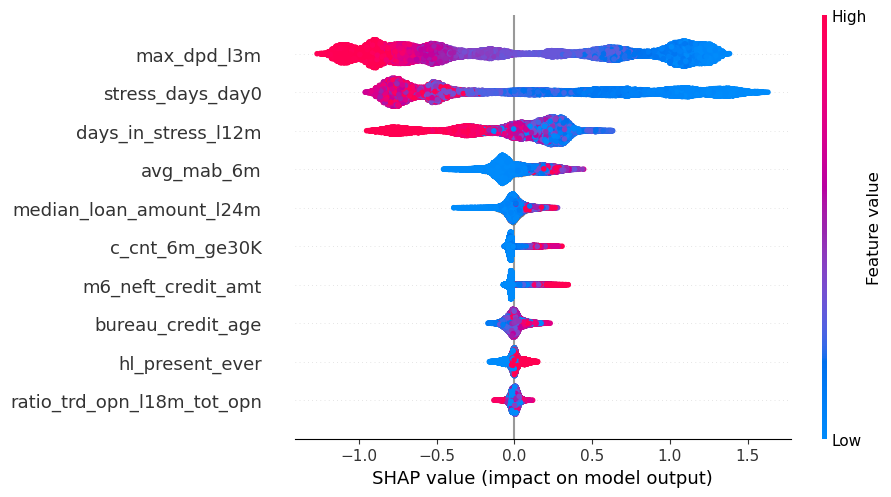

In [281]:
# checking if model has learnt on feature trends in expected directions

import shap
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_t[model_fts])

shap.plots.beeswarm(shap_values,max_display=40)

In [282]:
# shap_values.values
# len(shap_values.values)

In [283]:
# deciling the outputs to see rank order, ks etc...

def ks_fn(data, target, prob,cuts):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10,duplicates='drop')
    # print(data['bucket'].value_counts())
    grouped = data.groupby('bucket', as_index=False)
    # print()
    
    
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events'] = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
    kstable['event_rate'] =(kstable['events']/(kstable['events']+kstable['nonevents'])).apply('{0:.2%}'.format)
    kstable['event_capture_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_capture_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100
    
    # Formatting
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    # print(kstable)
    
    kstable.index = range(1,data['bucket'].nunique()+1)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 20)
    
    # print(kstable)
    
    # Display KS
    print(Fore.RED + "KS is " + str(max(kstable['KS'])) + "%" + " at decile " + str((kstable.index[kstable['KS'] == max(kstable['KS'])][0])))
    
    return kstable


In [284]:

predprob_xg =xgb_clf.predict_proba(X_t[model_fts])[:,1]

X_t['DV']=Y_train
X_t['Prediction']=predprob_xg.tolist()

In [285]:
X_ts.columns

Index(['stress_days_day0', 'ratio_trd_opn_l18m_tot_opn',
       'median_loan_amount_l24m', 'max_dpd_l3m', 'm6_neft_credit_amt',
       'days_in_stress_l12m', 'c_cnt_6m_ge30K', 'avg_mab_6m',
       'bureau_credit_age', 'hl_present_ever'],
      dtype='object')

In [286]:
predprob_xg =xgb_clf.predict_proba(X_ts[model_fts])[:,1]

X_ts['DV']=Y_test

X_ts['Prediction']=predprob_xg.tolist()

In [287]:
X_t.columns

Index(['stress_days_day0', 'ratio_trd_opn_l18m_tot_opn',
       'median_loan_amount_l24m', 'max_dpd_l3m', 'm6_neft_credit_amt',
       'days_in_stress_l12m', 'c_cnt_6m_ge30K', 'avg_mab_6m',
       'bureau_credit_age', 'hl_present_ever', 'DV', 'Prediction'],
      dtype='object')

In [288]:
# checking all performances below including OOT

KS_Table_train =ks_fn(X_t,'DV' ,'Prediction',10).sort_index(ascending = False)
display(KS_Table_train)

KS is 60.699999999999996% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.041056  0.088569     155       2775      5.29%              1.06%   
9       0.088574  0.143184     305       2625     10.41%              2.09%   
8       0.143190  0.219545     480       2449     16.39%              3.29%   
7       0.219596  0.314429     773       2157     26.38%              5.30%   
6       0.314455  0.467498    1131       1799     38.60%              7.76%   
5       0.467688  0.640291    1638       1291     55.92%             11.23%   
4       0.640399  0.779775    2104        826     71.81%             14.43%   
3       0.779790  0.875303    2445        484     83.48%             16.77%   
2       0.875308  0.933761    2709        221     92.46%             18.58%   
1       0.933778  0.979531    2843         87     97.03%             19.50%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.86%       100.00%          100.00%   0.0  
9                     17.84%        98.94%           81.14%  17.8  
8                     16.64%        96.85%           63.30%  33.5  
7                     14.66%        93.55%           46.66%  46.9  
6                     12.23%        88.25%           32.00%  56.3  
5                      8.77%        80.50%           19.77%  60.7  
4                      5.61%        69.27%           11.00%  58.3  
3                      3.29%        54.84%            5.38%  49.5  
2                      1.50%        38.07%            2.09%  36.0  
1                      0.59%        19.50%            0.59%  18.9

In [289]:
# KS_Table_test =KS(X_ts, 'Prediction','DV').sort_index(ascending = False)
KS_Table_test =ks_fn(X_ts,'DV' ,'Prediction',10).sort_index(ascending = False)
display(KS_Table_test)
# display(KS_Table_test)

KS is 59.0% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.042239  0.088887      98       1158      7.80%              1.56%   
9       0.088890  0.144100     160       1096     12.74%              2.54%   
8       0.144150  0.218536     218       1037     17.37%              3.47%   
7       0.218562  0.316968     338        918     26.91%              5.37%   
6       0.316987  0.477130     480        775     38.25%              7.63%   
5       0.477237  0.644006     697        559     55.49%             11.08%   
4       0.644036  0.783076     922        333     73.47%             14.66%   
3       0.783159  0.877522    1015        241     80.81%             16.14%   
2       0.877592  0.935362    1152        103     91.79%             18.32%   
1       0.935398  0.979218    1209         47     96.26%             19.22%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.48%       100.00%          100.00%   0.0  
9                     17.49%        98.44%           81.52%  16.9  
8                     16.55%        95.90%           64.03%  31.9  
7                     14.65%        92.43%           47.49%  44.9  
6                     12.37%        87.06%           32.84%  54.2  
5                      8.92%        79.42%           20.47%  59.0  
4                      5.31%        68.34%           11.55%  56.8  
3                      3.85%        53.68%            6.24%  47.4  
2                      1.64%        37.54%            2.39%  35.1  
1                      0.75%        19.22%            0.75%  18.5

In [290]:
threshold=0.470873
X_t['Y_Pred_New']=np.where(X_t['Prediction']>threshold,1,0)

In [291]:
# threshold=0.5
X_ts['Y_Pred_New']=np.where(X_ts['Prediction']>threshold,1,0)

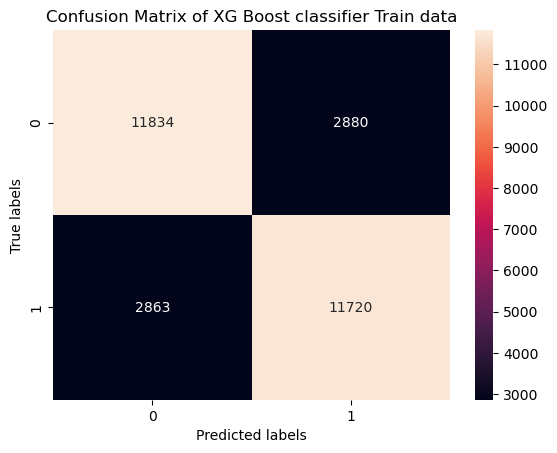

In [292]:
import seaborn as sns
import matplotlib.pyplot as plt


ax=plt.subplot()
sns.heatmap(confusion_matrix(Y_train, X_t['Y_Pred_New']), annot=True, ax=ax, fmt='g')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of XG Boost classifier Train data')
ax.xaxis.set_ticklabels(['0','1']); ax.yaxis.set_ticklabels(['0','1']);

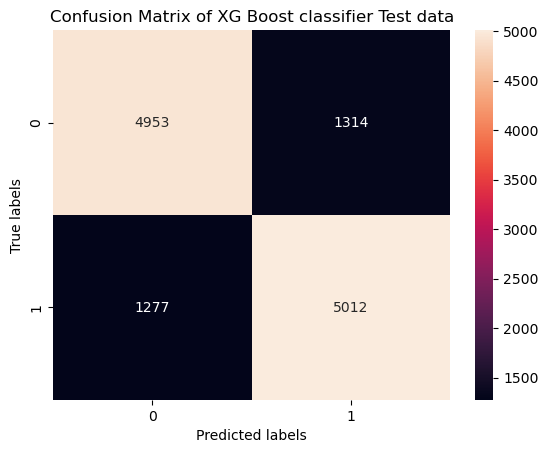

In [293]:
import seaborn as sns
import matplotlib.pyplot as plt


ax=plt.subplot()
sns.heatmap(confusion_matrix(Y_test, X_ts['Y_Pred_New']), annot=True, ax=ax, fmt='g')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of XG Boost classifier Test data')
ax.xaxis.set_ticklabels(['0','1']); ax.yaxis.set_ticklabels(['0','1']);

In [294]:
FPR, TPR,_=roc_curve(Y_train, X_t['Y_Pred_New'])

AUC_Train=auc(FPR, TPR)

print('Train AUC :', round(AUC_Train,4))

Train AUC : 0.804


In [295]:
FPR, TPR,_=roc_curve(Y_test, X_ts['Y_Pred_New'])

AUC_Test=auc(FPR, TPR)

print('Test AUC :', round(AUC_Test,4))

Test AUC : 0.7936


In [296]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy Score in Train:', round((accuracy_score(Y_train, X_t['Y_Pred_New'])),2))
print(classification_report(Y_train, X_t['Y_Pred_New']))

Accuracy Score in Train: 0.8
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     14714
           1       0.80      0.80      0.80     14583

    accuracy                           0.80     29297
   macro avg       0.80      0.80      0.80     29297
weighted avg       0.80      0.80      0.80     29297



In [297]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy Score in Test:', round((accuracy_score(Y_test, X_ts['Y_Pred_New'])),2))
print(classification_report(Y_test, X_ts['Y_Pred_New']))

Accuracy Score in Test: 0.79
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      6267
           1       0.79      0.80      0.79      6289

    accuracy                           0.79     12556
   macro avg       0.79      0.79      0.79     12556
weighted avg       0.79      0.79      0.79     12556



## OOT

In [298]:
import pickle
!pip install xgboost==1.7.5
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import RFE
import xgboost
from xgboost import XGBClassifier
# with open('xgb_8jul_cp.pkl', 'rb') as f:
    # Load the pickled dictionary
    # xgb_clf = pickle.load(f)



In [299]:
# drop mostly missing columns
print(df_oot.shape)


# df_oot=df_oot.drop([
#     'l3m_deposit_amt',
# 'l3m_deposit_cnt',
# 'l6m_deposit_amt',
# 'l6m_deposit_cnt',
# 'total_promised_paid_l1m',
# 'tot_promised_l1m',
# 'total_promised_paid_l3m',
# 'total_promised_paid_l6m',
# 'month_since_gl_inq_l24m',
# 'tot_promised_l3m',
# 'promised_to_pay_date',
# 'tot_promised_l6m',
# 'tot_promised_amt'],axis=1)

print(df_oot.shape)

(49769, 441)
(49769, 441)


In [300]:
df_oot['c_cnt_6m_ge30K'] =df_oot['c_cnt_6m_30k_50k']+df_oot['c_cnt_6m_50k_75k']+df_oot['c_cnt_6m_75k_1l']+df_oot['c_cnt_6m_1l_and_above']

In [301]:
with open('numeric_cols_cp.pkl', 'rb') as f:
    # Load the pickled dictionary
    numeric_cols = pickle.load(f)
    
with open('cols_bool_cp.pkl', 'rb') as f:
    # Load the pickled dictionary
    cols_bool = pickle.load(f)

with open('percentiles_dict_cp.pkl', 'rb') as f:
    # Load the pickled dictionary
    percentiles_dict = pickle.load(f)

In [302]:
percentiles_dict.get('overdue_amt_l6m')

(0.0, 187405306.34719998)

In [303]:
ser_a=pd.Series(numeric_cols)
result = ser_a[ser_a.isin(model_fts)]

for col in result:
    if col not in cols_bool:
        if col in df_oot.columns.to_list():
            # print(col)
            df_oot[col][df_oot[col] <= percentiles_dict.get(col)[0]] = percentiles_dict.get(col)[0]
            df_oot[col][df_oot[col] >= percentiles_dict.get(col)[1]] = percentiles_dict.get(col)[1]


In [304]:
df_oot_test=df_oot[df_oot['snap_dt']=='2024-01-31']
# df_oot_test.to_csv('correlation_step_cp.csv')

In [305]:
df_oot_test[df_oot_test['no_inq_l12m']==0].head(10)

cust_id     snap_dt  good dev  active_loans  active_loans_outstanding  \
6    707115774  2024-01-31     0   0             1                  25983.62   
39   332001860  2024-01-31     0   0             1                5135250.34   
95   R00185556  2024-01-31     1   0             1                1631157.72   
97   056018579  2024-01-31     1   0             1                3554521.55   
101  801117897  2024-01-31     0   0             1                 725989.05   
108  R01358092  2024-01-31     0   0             1                   7756.18   
152  760078548  2024-01-31     0   0             2               11702435.36   
155  598113362  2024-01-31     1   0             1                5680073.56   
196  507020654  2024-01-31     1   0            12               18847633.70   
198  R00850498  2024-01-31     0   0             4                1847758.95   

     active_loans_sanctions  active_oda_outstanding  active_oda_sanctions  \
6                         1                     NaN                     0   
39                        1                     NaN                     0   
95                        1                     NaN                     0   
97                        1                     NaN                     0   
101                       1                     NaN                     0   
108                       1                     NaN                     0   
152                       1               4860540.0                     1   
155                       1                     NaN                     0   
196                       9              25470648.0                     3   
198                       4                     NaN                     0   

     avg_followups_perdelq_l1m  ...  td_flag  max_follow_up_l1m_A002  \
6                     1.400000  ...        0                       1   
39                    1.769231  ...        0                       0   
95                    1.750000  ...        0                       1   
97                    1.666667  ...        0                       1   
101                   1.800000  ...        0                       1   
108                   1.000000  ...        0                       0   
152                   3.000000  ...        0                       0   
155                   1.142857  ...        1                       1   
196                   1.071429  ...        0                       1   
198                   1.714286  ...        0                       0   

     max_follow_up_l1m_A005     stress_cat_1to30  stress_cat_31to60  \
6                         0  0                 1                  0   
39                        0  0                 1                  0   
95                        0  0                 1                  0   
97                        0  0                 1                  0   
101                       0  0                 0                  0   
108                       0  0                 0                  1   
152                       0  0                 0                  1   
155                       0  0                 1                  0   
196                       0  0                 1                  0   
198                       1  1                 0                  0   

     stress_cat_61to90  c_cnt_6m_ge30K  Pred_Score  Y_Pred_New  
6                    0               1    0.715240           1  
39                   0               0    0.440541           0  
95                   0               0    0.646964           1  
97                   0               0    0.598299           1  
101                  1               0    0.065136           0  
108                  0               1    0.215438           0  
152                  0               0    0.324694           0  
155                  0               0    0.958556           1  
196                  0               0    0.437953           0  
198                  1               0    0.073631   

In [306]:
df_oot_test[['cust_id']+model_fts].describe()

stress_days_day0  ratio_trd_opn_l18m_tot_opn  median_loan_amount_l24m  \
count       9868.000000                 9868.000000             7.361000e+03   
mean          33.251723                    0.290408             5.741367e+05   
std           29.052907                    0.272582             1.346154e+06   
min            1.000000                    0.000000             1.000000e+03   
25%            6.000000                    0.000000             4.200000e+04   
50%           24.000000                    0.250000             1.200000e+05   
75%           63.000000                    0.466667             4.644090e+05   
max           87.000000                    1.000000             1.000000e+07   

       max_dpd_l3m  m6_neft_credit_amt  days_in_stress_l12m  c_cnt_6m_ge30K  \
count  9868.000000        9.868000e+03          9868.000000     9868.000000   
mean     45.293373        7.554092e+04           171.762667        3.203081   
std      32.556355        3.122829e+05           113.784278        9.878398   
min       1.000000        0.000000e+00             2.000000        0.000000   
25%      14.000000        0.000000e+00            66.000000        0.000000   
50%      40.000000        0.000000e+00           161.000000        0.000000   
75%      81.000000        0.000000e+00           284.000000        1.000000   
max      90.000000        2.432357e+06           336.000000       68.000000   

          avg_mab_6m  bureau_credit_age  hl_present_ever  
count    9467.000000        9868.000000      9868.000000  
mean     8084.809050         118.855188         0.498987  
std     27211.873091          57.251867         0.500024  
min         0.000000           9.000000         0.000000  
25%        79.575000          77.000000         0.000000  
50%       571.043616         115.000000         0.000000  
75%      3042.942659         156.000000         1.000000  
max    203772.245294         256.000000         1.000000

In [307]:
df3=pd.read_parquet("s3://576118004139-ap-south-1-kbl-datamart-l2/datamartl2/collection_prioritization_v2/model_features/model_scoring_data.parquet")
df3['stress_days_day0']=df3['stress_days_day0'].astype(float)
# df3['no_months_no_del_l12m']=df3['no_months_no_del_l12m']+1

df3[model_fts].describe()

stress_days_day0  ratio_trd_opn_l18m_tot_opn  median_loan_amount_l24m  \
count      10771.000000                10592.000000             7.582000e+03   
mean          33.245752                    0.215647             5.731388e+05   
std           27.924398                    0.259005             1.363417e+06   
min            1.000000                    0.000000             1.000000e+03   
25%            8.000000                    0.000000             3.069875e+04   
50%           23.000000                    0.140488             1.040000e+05   
75%           60.000000                    0.311184             4.701875e+05   
max           87.000000                    1.000000             1.000000e+07   

        max_dpd_l3m  m6_neft_credit_amt  days_in_stress_l12m  c_cnt_6m_ge30K  \
count  10771.000000        1.077000e+04         10771.000000    10643.000000   
mean      45.603472        6.844594e+04           169.045214        3.296721   
std       32.088514        2.822712e+05           116.180489        7.754011   
min        1.000000        0.000000e+00             2.000000        0.000000   
25%       15.000000        0.000000e+00            60.000000        0.000000   
50%       40.000000        0.000000e+00           156.000000        0.000000   
75%       82.000000        2.043500e+03           287.000000        3.000000   
max       90.000000        2.432357e+06           335.000000       68.000000   

          avg_mab_6m  bureau_credit_age  hl_present_ever  
count   10279.000000       10592.000000     10592.000000  
mean     7037.412024         254.682874         0.485366  
std     24556.424300          11.250715         0.499809  
min         0.000000          76.000000         0.000000  
25%        76.215000         256.000000         0.000000  
50%       560.897850         256.000000         0.000000  
75%      2888.613966         256.000000         1.000000  
max    203772.245294         256.000000         1.000000

In [308]:
# new_order=["stress_days_day0", "ratio_trd_opn_l18m_tot_opn",    "overdue_amt_l6m",    "no_months_no_del_l12m",    "median_loan_amount_l24m",    "max_sanc_amt_unsecured_l18m",    "max_dpd_l3m",    "m6_neft_credit_amt",    "days_in_stress_l12m","c_cnt_6m_ge_30k","avg_mab_6m","active_oda_sanctions","bureau_credit_age","hl_present_ever","no_inq_l12m"]
# df3=df3.reindex(columns=new_order)
df3['no_months_no_del_l12m'].value_counts()

no_months_no_del_l12m
0     3223
11    1101
1     1086
10     758
2      704
3      640
9      570
7      560
4      558
8      556
5      546
6      469
Name: count, dtype: int64

In [309]:
df3[df3['no_inq_l12m']==1].head(10)

cust_id  stress_days_day0  ratio_trd_opn_l18m_tot_opn  overdue_amt_l6m  \
14   745115611              28.0                    0.000000        1303216.0   
15   937112599               7.0                    1.000000            885.0   
28   R01840437              16.0                    0.190476         520835.0   
30   R03484024               9.0                    0.229508        4499975.0   
34   107021838              48.0                    0.242424           1227.0   
39   331067946              21.0                    0.071429          34834.0   
53   R01887048               3.0                    0.090909           1049.0   
70   734105127               2.0                    0.166667           6266.0   
74   R00057365              64.0                    0.400000        1402918.0   
117  388110247              21.0                    0.176471          10269.0   

     no_months_no_del_l12m  median_loan_amount_l24m  \
14                       0                      NaN   
15                       2                  10000.0   
28                       1               10000000.0   
30                       9                 330000.0   
34                       9                3000000.0   
39                       7                 203000.0   
53                       7                  10000.0   
70                       7                  10000.0   
74                       0                  26820.0   
117                      7                 200000.0   

     max_sanc_amt_unsecured_l18m  max_dpd_l3m  m6_neft_credit_amt  \
14                           NaN         49.0                 0.0   
15                       10000.0          7.0                 0.0   
28                     9000000.0         16.0            343035.0   
30                     9000000.0          9.0             40000.0   
34                           0.0         48.0                 0.0   
39                           0.0         21.0                 0.0   
53                       10000.0          3.0                 0.0   
70                       38946.0         11.0            184648.0   
74                       23433.0         89.0                 0.0   
117                          NaN         21.0                 0.0   

     days_in_stress_l12m  c_cnt_6m_ge30K     avg_mab_6m  active_oda_sanctions  \
14                   273             4.0            NaN                     0   
15                    15             0.0      59.481434                     0   
28                    18            16.0  165697.222929                     0   
30                    12             4.0   14281.923104                     0   
34                   263            23.0   43786.081377                     0   
39                    52             0.0     457.451613                     0   
53                   113             0.0     872.804500                     0   
70                    15             3.0    7421.881944                     0   
74                   335            10.0     472.080645                     0   
117                   43             8.0   10984.916957                     0   

     bureau_credit_age  hl_present_ever  no_inq_l12m  
14               256.0              1.0          1.0  
15               129.0              0.0          1.0  
28               256.0              1.0          1.0  
30               256.0              1.0          1.0  
34               256.0              1.0          1.0  
39               256.0              1.0          1.0  
53               256.0              0.0          1.0  
70               256.0              0.0          1.0  
74               256.0              1.0          1.0  
117              256.0              0.0          1.0

In [310]:
df_oot_test['no_months_no_del_l12m'].value_counts()

no_months_no_del_l12m
0     2924
1      921
12     697
2      640
3      564
9      554
8      528
11     527
4      523
5      513
7      510
10     500
6      467
Name: count, dtype: int64

In [311]:
df_test=df_oot_test[df_oot_test['no_months_no_del_l12m']==12]

In [312]:
# df_test['model'].to_csv('data_compare.csv')

In [313]:
threshold=0.470873
df_oot["Pred_Score"]=xgb_clf.predict_proba(df_oot[model_fts])[:,1]
df_oot['Y_Pred_New']=np.where(df_oot['Pred_Score']>threshold,1,0)

In [314]:
model_fts

['stress_days_day0',
 'ratio_trd_opn_l18m_tot_opn',
 'median_loan_amount_l24m',
 'max_dpd_l3m',
 'm6_neft_credit_amt',
 'days_in_stress_l12m',
 'c_cnt_6m_ge30K',
 'avg_mab_6m',
 'bureau_credit_age',
 'hl_present_ever']

In [315]:
print(xgb_clf.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'eval_metric': 'auc', 'gamma': 1, 'gpu_id': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.07, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': 2, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 55, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': 2, 'reg_lambda': 3, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.75, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'nthread': 8, 'seed': 27}


In [316]:
df_oot['good'].value_counts()

good
1    25223
0    24546
Name: count, dtype: int64

In [317]:
# df_oot['bad'].value_counts()

In [318]:
df_oot.shape[0]

49769

In [319]:
# KS_Table_OOT =decile_report(df_oot, 'Pred_Score','good').sort_index(ascending = False)
# display(KS_Table_OOT)
# oot_months=df_oot['snap_dt'].unique()
# oot_months.sort()
# print(oot_months)
# for i in oot_months:
    # print(f'event rate is : {(df_oot[df_oot.good==1].shape[0])/(df_oot.shape[0])} ')
# print(f'KS for OOT month : {i}')
Oot_t=df_oot.copy()

FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
AUC_cut=auc(FPR, TPR)
print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
AUC_cut=auc(FPR, TPR)
print(confusion_matrix(Oot_t['good'], Oot_t['Y_Pred_New']))
print(f'AUC for OOT month is : {AUC_cut} ')
# print(f'AUC for OOT month {i} is : {AUC_cut} ')
print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
Oot_t=Oot_t[model_fts+["Pred_Score",'good']]
KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
display(KS_Table_oot)
    

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     24546
           1       0.79      0.82      0.81     25223

    accuracy                           0.80     49769
   macro avg       0.80      0.80      0.80     49769
weighted avg       0.80      0.80      0.80     49769

[[19126  5420]
 [ 4511 20712]]
AUC for OOT month is : 0.8697387405055775 
event rate is : 0.506801422572284 
KS is 60.4% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.041598  0.097573     328       4649      6.59%              1.30%   
9       0.097581  0.149018     556       4421     11.17%              2.20%   
8       0.149021  0.225358     872       4105     17.52%              3.46%   
7       0.225358  0.334585    1331       3646     26.74%              5.28%   
6       0.334602  0.531832    2016       2961     40.51%              7.99%   
5       0.531884  0.711663    2945       2031     59.18%             11.68%   
4       0.711706  0.839713    3855       1122     77.46%             15.28%   
3       0.839736  0.910722    4237        740     85.13%             16.80%   
2       0.910733  0.949377    4471        506     89.83%             17.73%   
1       0.949378  0.980401    4612        365     92.67%             18.28%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.94%       100.00%          100.00%   0.0  
9                     18.01%        98.70%           81.06%  17.6  
8                     16.72%        96.50%           63.05%  33.4  
7                     14.85%        93.04%           46.33%  46.7  
6                     12.06%        87.76%           31.47%  56.3  
5                      8.27%        79.77%           19.41%  60.4  
4                      4.57%        68.09%           11.13%  57.0  
3                      3.01%        52.81%            6.56%  46.2  
2                      2.06%        36.01%            3.55%  32.5  
1                      1.49%        18.28%            1.49%  16.8

In [320]:
# df3
df3["Pred_Score"]=xgb_clf.predict_proba(df3[model_fts])[:,1]


In [321]:
df3.to_csv('new_scores.csv')

In [322]:
# KS_Table_OOT =decile_report(df_oot, 'Pred_Score','good').sort_index(ascending = False)
# display(KS_Table_OOT)
oot_months=df_oot['snap_dt'].unique()
oot_months.sort()
# print(oot_months)
for i in oot_months:
    # print(f'event rate is : {(df_oot[df_oot.good==1].shape[0])/(df_oot.shape[0])} ')
    print(f'KS for OOT month : {i}')

    Oot_t=df_oot[df_oot['snap_dt']==i]
    
    FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
    AUC_cut=auc(FPR, TPR)
    print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
    FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
    AUC_cut=auc(FPR, TPR)
    # print(f'AUC for OOT month {i} is : {AUC_cut} ')
    print(f'AUC for OOT month {i} is : {AUC_cut} ')
    print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
    Oot_t=Oot_t[model_fts+["Pred_Score",'good']]
    KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
    display(KS_Table_oot)
    

KS for OOT month : 2023-01-31
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      3860
           1       0.80      0.82      0.81      3782

    accuracy                           0.81      7642
   macro avg       0.81      0.81      0.81      7642
weighted avg       0.81      0.81      0.81      7642

AUC for OOT month 2023-01-31 is : 0.8805161071122277 
event rate is : 0.49489662392043965 
KS is 62.2% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.042497  0.093649      44        721      5.75%              1.16%   
9       0.093755  0.146646      84        680     10.99%              2.22%   
8       0.146760  0.217928     121        643     15.84%              3.20%   
7       0.217990  0.307150     185        579     24.21%              4.89%   
6       0.307218  0.474251     268        496     35.08%              7.09%   
5       0.474743  0.653074     444        320     58.12%             11.74%   
4       0.653087  0.791587     573        191     75.00%             15.15%   
3       0.791641  0.884084     635        129     83.12%             16.79%   
2       0.884139  0.935063     687         77     89.92%             18.16%   
1       0.935138  0.979491     741         24     96.86%             19.59%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.68%       100.00%          100.00%   0.0  
9                     17.62%        98.84%           81.32%  17.5  
8                     16.66%        96.62%           63.70%  32.9  
7                     15.00%        93.42%           47.05%  46.4  
6                     12.85%        88.52%           32.05%  56.5  
5                      8.29%        81.44%           19.20%  62.2  
4                      4.95%        69.70%           10.91%  58.8  
3                      3.34%        54.55%            5.96%  48.6  
2                      1.99%        37.76%            2.62%  35.1  
1                      0.62%        19.59%            0.62%  19.0

KS for OOT month : 2023-12-31
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      4921
           1       0.82      0.82      0.82      5096

    accuracy                           0.82     10017
   macro avg       0.82      0.82      0.82     10017
weighted avg       0.82      0.82      0.82     10017

AUC for OOT month 2023-12-31 is : 0.8897293285719708 
event rate is : 0.5087351502445842 
KS is 63.5% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.058363  0.114731      68        934      6.79%              1.33%   
9       0.114732  0.153962     105        897     10.48%              2.06%   
8       0.154228  0.221723     144        857     14.39%              2.83%   
7       0.221803  0.316409     264        738     26.35%              5.18%   
6       0.316662  0.485419     378        624     37.72%              7.42%   
5       0.485443  0.675660     592        409     59.14%             11.62%   
4       0.675741  0.810417     762        240     76.05%             14.95%   
3       0.810553  0.892965     863        138     86.21%             16.93%   
2       0.892992  0.942974     936         66     93.41%             18.37%   
1       0.942981  0.978673     984         18     98.20%             19.31%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.98%       100.00%          100.00%  -0.0  
9                     18.23%        98.67%           81.02%  17.6  
8                     17.42%        96.61%           62.79%  33.8  
7                     15.00%        93.78%           45.38%  48.4  
6                     12.68%        88.60%           30.38%  58.2  
5                      8.31%        81.18%           17.70%  63.5  
4                      4.88%        69.56%            9.39%  60.2  
3                      2.80%        54.61%            4.51%  50.1  
2                      1.34%        37.68%            1.71%  36.0  
1                      0.37%        19.31%            0.37%  18.9

KS for OOT month : 2024-01-31
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      5086
           1       0.81      0.81      0.81      4782

    accuracy                           0.81      9868
   macro avg       0.81      0.81      0.81      9868
weighted avg       0.81      0.81      0.81      9868

AUC for OOT month 2024-01-31 is : 0.8880865795889126 
event rate is : 0.48459667612484797 
KS is 62.6% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.041598  0.088833      49        938      4.96%              1.02%   
9       0.088849  0.138381      98        889      9.93%              2.05%   
8       0.138383  0.208576     146        841     14.79%              3.05%   
7       0.208619  0.299109     217        769     22.01%              4.54%   
6       0.299121  0.449629     338        649     34.25%              7.07%   
5       0.449641  0.650589     518        469     52.48%             10.83%   
4       0.650696  0.796217     708        278     71.81%             14.81%   
3       0.796254  0.886439     832        155     84.30%             17.40%   
2       0.886466  0.938943     922         65     93.41%             19.28%   
1       0.938968  0.978833     954         33     96.66%             19.95%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.44%       100.00%          100.00%   0.0  
9                     17.48%        98.98%           81.56%  17.4  
8                     16.54%        96.93%           64.08%  32.8  
7                     15.12%        93.87%           47.54%  46.3  
6                     12.76%        89.34%           32.42%  56.9  
5                      9.22%        82.27%           19.66%  62.6  
4                      5.47%        71.43%           10.44%  61.0  
3                      3.05%        56.63%            4.97%  51.7  
2                      1.28%        39.23%            1.93%  37.3  
1                      0.65%        19.95%            0.65%  19.3

KS for OOT month : 2024-02-29
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      4788
           1       0.84      0.80      0.82      5874

    accuracy                           0.80     10662
   macro avg       0.80      0.80      0.80     10662
weighted avg       0.81      0.80      0.80     10662

AUC for OOT month 2024-02-29 is : 0.8806771959122639 
event rate is : 0.5509285312324141 
KS is 61.1% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.041598  0.090280      91        976      8.53%              1.55%   
9       0.090312  0.143579     141        925     13.23%              2.40%   
8       0.143624  0.220726     257        809     24.11%              4.38%   
7       0.220997  0.332160     341        725     31.99%              5.81%   
6       0.332196  0.528812     494        572     46.34%              8.41%   
5       0.528942  0.716890     669        397     62.76%             11.39%   
4       0.716920  0.847189     869        197     81.52%             14.79%   
3       0.847251  0.915142     955        111     89.59%             16.26%   
2       0.915186  0.951212    1005         61     94.28%             17.11%   
1       0.951222  0.980401    1052         15     98.59%             17.91%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    20.38%       100.00%          100.00%   0.0  
9                     19.32%        98.45%           79.62%  18.8  
8                     16.90%        96.05%           60.30%  35.8  
7                     15.14%        91.68%           43.40%  48.3  
6                     11.95%        85.87%           28.26%  57.6  
5                      8.29%        77.46%           16.31%  61.1  
4                      4.11%        66.07%            8.02%  58.1  
3                      2.32%        51.28%            3.91%  47.4  
2                      1.27%        35.02%            1.59%  33.4  
1                      0.31%        17.91%            0.31%  17.6

KS for OOT month : 2024-03-31
              precision    recall  f1-score   support

           0       0.83      0.67      0.75      5891
           1       0.72      0.86      0.78      5689

    accuracy                           0.77     11580
   macro avg       0.78      0.77      0.76     11580
weighted avg       0.78      0.77      0.76     11580

AUC for OOT month 2024-03-31 is : 0.8328307905922854 
event rate is : 0.4912780656303972 
KS is 54.900000000000006% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.041870  0.093831      67       1091      5.79%              1.18%   
9       0.093842  0.162189     135       1023     11.66%              2.37%   
8       0.162191  0.261257     217        941     18.74%              3.81%   
7       0.261456  0.437417     325        833     28.07%              5.71%   
6       0.437418  0.667459     511        647     44.13%              8.98%   
5       0.667669  0.823126     740        418     63.90%             13.01%   
4       0.823420  0.901196     866        292     74.78%             15.22%   
3       0.901222  0.939285     915        243     79.02%             16.08%   
2       0.939288  0.958191     951        207     82.12%             16.72%   
1       0.958202  0.980138     962        196     83.07%             16.91%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    18.52%       100.00%          100.00%  -0.0  
9                     17.37%        98.82%           81.48%  17.3  
8                     15.97%        96.45%           64.11%  32.3  
7                     14.14%        92.63%           48.14%  44.5  
6                     10.98%        86.92%           34.00%  52.9  
5                      7.10%        77.94%           23.02%  54.9  
4                      4.96%        64.93%           15.92%  49.0  
3                      4.12%        49.71%           10.97%  38.7  
2                      3.51%        33.63%            6.84%  26.8  
1                      3.33%        16.91%            3.33%  13.6

In [323]:
oot_cat=df_oot['stress_cat_day0'].unique()
oot_cat.sort()
# stress_cat_day0
# print(oot_cat)
for i in oot_cat:
    if i=='SMA0':
        threshold=0.782977
    elif i=='SMA1':
        threshold=0.237081
    else:
        threshold=0.134735
    df_oot['Y_Pred_New']=np.where(df_oot['Pred_Score']>threshold,1,0)
    print(f'KS for OOT bucket : {i}')
    Oot_t=df_oot[df_oot['stress_cat_day0']==i]
    Oot_t=Oot_t[model_fts+["Pred_Score",'good','Y_Pred_New']]
    FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
    print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
    FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
    AUC_cut=auc(FPR, TPR)
    AUC_cut=auc(FPR, TPR)
    # print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
    print(f'AUC for OOT month {i} is : {AUC_cut} ')
    print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
    Oot_t=Oot_t[model_fts+["Pred_Score",'good']]
    KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
    display(KS_Table_oot)

KS for OOT bucket : SMA0
              precision    recall  f1-score   support

           0       0.45      0.70      0.55      7122
           1       0.88      0.71      0.79     21548

    accuracy                           0.71     28670
   macro avg       0.66      0.71      0.67     28670
weighted avg       0.77      0.71      0.73     28670

AUC for OOT month SMA0 is : 0.767676952695932 
event rate is : 0.7515870247645623 
KS is 41.6% at decile 6


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.113146  0.471807    1010       1857     35.23%              4.69%   
9       0.471897  0.607493    1490       1377     51.97%              6.91%   
8       0.607549  0.706807    1773       1094     61.84%              8.23%   
7       0.706861  0.789560    2118        749     73.88%              9.83%   
6       0.789585  0.850788    2318        549     80.85%             10.76%   
5       0.850796  0.893669    2430        437     84.76%             11.28%   
4       0.893686  0.922796    2540        327     88.59%             11.79%   
3       0.922798  0.944678    2569        298     89.61%             11.92%   
2       0.944684  0.960830    2626        241     91.59%             12.19%   
1       0.960837  0.980401    2674        193     93.27%             12.41%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    26.07%       100.00%          100.00%  -0.0  
9                     19.33%        95.31%           73.93%  21.4  
8                     15.36%        88.40%           54.59%  33.8  
7                     10.52%        80.17%           39.23%  40.9  
6                      7.71%        70.34%           28.71%  41.6  
5                      6.14%        59.58%           21.01%  38.6  
4                      4.59%        48.31%           14.87%  33.4  
3                      4.18%        36.52%           10.28%  26.2  
2                      3.38%        24.60%            6.09%  18.5  
1                      2.71%        12.41%            2.71%   9.7

KS for OOT bucket : SMA1
              precision    recall  f1-score   support

           0       0.87      0.64      0.73      7403
           1       0.30      0.62      0.41      1906

    accuracy                           0.63      9309
   macro avg       0.58      0.63      0.57      9309
weighted avg       0.75      0.63      0.67      9309

AUC for OOT month SMA1 is : 0.6790932223245759 
event rate is : 0.2047480932430981 
KS is 25.3% at decile 5


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.043506  0.096238      58        873      6.23%              3.04%   
9       0.096261  0.122538      80        851      8.59%              4.20%   
8       0.122539  0.153308     128        803     13.75%              6.72%   
7       0.153453  0.182647     136        795     14.61%              7.14%   
6       0.182781  0.212668     168        763     18.05%              8.81%   
5       0.212689  0.240756     196        734     21.08%             10.28%   
4       0.240772  0.271784     220        711     23.63%             11.54%   
3       0.271798  0.327275     235        696     25.24%             12.33%   
2       0.327440  0.384502     283        648     30.40%             14.85%   
1       0.384727  0.679003     402        529     43.18%             21.09%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    11.79%       100.00%          100.00%   0.0  
9                     11.50%        96.96%           88.21%   8.7  
8                     10.85%        92.76%           76.71%  16.0  
7                     10.74%        86.04%           65.87%  20.2  
6                     10.31%        78.91%           55.13%  23.8  
5                      9.91%        70.09%           44.82%  25.3  
4                      9.60%        59.81%           34.90%  24.9  
3                      9.40%        48.27%           25.30%  23.0  
2                      8.75%        35.94%           15.90%  20.0  
1                      7.15%        21.09%            7.15%  13.9

KS for OOT bucket : SMA2
              precision    recall  f1-score   support

           0       0.92      0.60      0.73     10021
           1       0.23      0.69      0.35      1769

    accuracy                           0.61     11790
   macro avg       0.58      0.65      0.54     11790
weighted avg       0.81      0.61      0.67     11790

AUC for OOT month SMA2 is : 0.7040860885188025 
event rate is : 0.15004240882103478 
KS is 30.099999999999998% at decile 3


min_prob  max_prob  events  nonevents event_rate event_capture_rate  \
Decile                                                                        
10      0.041598  0.066112      61       1118      5.17%              3.45%   
9       0.066122  0.078473      76       1103      6.45%              4.30%   
8       0.078517  0.091135      91       1088      7.72%              5.14%   
7       0.091136  0.107814     108       1071      9.16%              6.11%   
6       0.107899  0.124739     117       1062      9.92%              6.61%   
5       0.124766  0.145288     157       1022     13.32%              8.88%   
4       0.145297  0.174897     175       1004     14.84%              9.89%   
3       0.174915  0.216101     230        949     19.51%             13.00%   
2       0.216117  0.280548     301        878     25.53%             17.02%   
1       0.280589  0.567240     453        726     38.42%             25.61%   

       nonevent_capture_rate cum_eventrate cum_noneventrate    KS  
Decile                                                             
10                    11.16%       100.00%          100.00%   0.0  
9                     11.01%        96.55%           88.84%   7.7  
8                     10.86%        92.26%           77.84%  14.4  
7                     10.69%        87.11%           66.98%  20.1  
6                     10.60%        81.01%           56.29%  24.7  
5                     10.20%        74.39%           45.69%  28.7  
4                     10.02%        65.52%           35.50%  30.0  
3                      9.47%        55.62%           25.48%  30.1  
2                      8.76%        42.62%           16.01%  26.6  
1                      7.24%        25.61%            7.24%  18.4

In [324]:
df_oot['exposure_bucket'] = pd.qcut(df_oot['exposure'], 4,duplicates='drop')
# df_oot['exposure_bucket'].value_counts()
# threshold=0.468976
# df_oot["Pred_Score"]=xgb_clf.predict_proba(df_oot[model_fts])[:,1]
df_oot['Y_Pred_New']=np.where(df_oot['Pred_Score']>threshold,1,0)

In [ ]:
oot_cat=df_oot['exposure_bucket'].unique()
# oot_cat.sort()
# stress_cat_day0
# print(oot_cat)
for i in oot_cat:
    if i is not np.nan:
        print(f'KS for OOT bucket : {i}')
        Oot_t=df_oot[df_oot['exposure_bucket']==i]
        Oot_t=Oot_t[model_fts+["Pred_Score",'good']]
        FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
        AUC_cut=auc(FPR, TPR)
        print(f'AUC for OOT month {i} is : {AUC_cut} ')
        print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
        KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
        display(KS_Table_oot)


In [ ]:
df_oot.columns


In [ ]:
# oot_cat=df_oot['retail_flag'].unique()
# oot_cat.sort()
# stress_cat_day0
# print(oot_cat)

print('KS for OOT bucket : retail')
Oot_t=df_oot[df_oot['retail_flag']==1]
Oot_t=Oot_t[model_fts+["Pred_Score",'good','Y_Pred_New']]
FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
AUC_cut=auc(FPR, TPR)
print(f'AUC for OOT month retail is : {AUC_cut} ')
print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
display(KS_Table_oot)

print('KS for OOT bucket : msme')
Oot_t=df_oot[df_oot['msme_loan']==1]
Oot_t=Oot_t[model_fts+["Pred_Score",'good','Y_Pred_New']]
FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
FPR, TPR,_=roc_curve(Oot_t['good'], Oot_t['Pred_Score'])
print(classification_report(Oot_t['good'], Oot_t['Y_Pred_New']))
AUC_cut=auc(FPR, TPR)
print(f'AUC for OOT month msme is : {AUC_cut} ')
print(f'event rate is : {(Oot_t[Oot_t.good==1].shape[0])/(Oot_t.shape[0])} ')
KS_Table_oot =ks_fn(Oot_t,'good' ,'Pred_Score',10).sort_index(ascending = False)
display(KS_Table_oot)


In [ ]:
threshold=0.5
df_oot['Y_Pred_New']=np.where(df_oot['Pred_Score']>threshold,1,0)

In [ ]:
FPR, TPR,_=roc_curve(df_oot['good'], df_oot['Y_Pred_New'])

AUC_Train=auc(FPR, TPR)

print('OOT AUC :', round(AUC_Train,4))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('Accuracy Score in OOT:', round((accuracy_score(df_oot['good'], df_oot['Y_Pred_New'])),2))
print(classification_report(df_oot['good'], df_oot['Y_Pred_New']))

In [ ]:
def lift_chart(X,actual_target,model):
    avg_tgt = actual_target.sum()/len(actual_target)
    df_data = X.copy()
    X_data = df_data.copy()
    df_data['Actual'] = actual_target
    df_data['Predict']= model.predict(X_data)
    y_Prob = pd.DataFrame(model.predict_proba(X_data))
    df_data['Prob_1']=list(y_Prob[1])
    df_data.sort_values(by=['Prob_1'],ascending=False,inplace=True)
    df_data.reset_index(drop=True,inplace=True)
    df_data['Decile']=pd.qcut(df_data.index,10,labels=False)
    output_df = pd.DataFrame()
    grouped = df_data.groupby('Decile',as_index=False)
    output_df['Max_Scr']=grouped.max().Prob_1
    output_df['Min_Scr']=grouped.min().Prob_1
    output_df['Actual']=grouped.sum().Actual
    output_df['Total']=grouped.count().Actual
    output_df["Population_perc"] = (output_df["Total"]/len(actual_target))*100
    output_df['Per_Events'] = (output_df['Actual']/output_df['Actual'].sum())*100
    output_df['Gain_Percentage'] = output_df.Per_Events.cumsum()
    output_df["Cumulative_Population"] = output_df.Population_perc.cumsum()
    output_df["Lift"] = output_df["Gain_Percentage"]/output_df["Cumulative_Population"]
    return output_df

In [ ]:
lift_oot =lift_chart(df_oot[model_fts],df_oot['good'],xgb_clf)

In [ ]:
lift_oot.head(10)

In [ ]:
# pickling part keep this commented unless you are saving the model to avoid overwrite

# with open('xgb_8jul_cp.pkl', 'wb') as f:
#     pickle.dump(xgb_clf, f)

# pickle.dump(xgb_clf)

In [ ]:
# pip install statsmodels==0.14.0

In [ ]:


# with open('xgb_1jul_cp.pkl', 'wb') as f:
#     pickle.dump(xgb_clf, f)

# pickle.dump(xgb_clf)